In [1]:
import os
import tensorflow as tf
import numpy as np
from galaxy2galaxy import problems
import matplotlib.pyplot as plt
from absl import flags, app

In [2]:
sigma_noise = 23.59

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # Add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb
    
    sigma_cfht = sigma_noise
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma_cfht, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise

    return dico['inputs'], dico['targets'], dico['flux_radius']

In [3]:
# Let's create an instance of the hsc_problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('attrs2img_cosmos_cfht2hst')
dset = problem128.dataset(Modes.EVAL, data_dir='/local/home/ua264756/Data/attrs2img_cosmos_cfht2hst')
dset = dset.repeat()
dset = dset.map(pre_proc_unet)
n_batch = 128
dset = dset.batch(n_batch)

# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()

sess = tf.Session()

# Initialize batch
batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/attrs2img_cosmos_cfht2hst/attrs2img_cosmos_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [4]:
# Load the U-Net model

model = tf.keras.models.load_model('Models/UNet_basic', compile=False)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (Non

In [5]:
# The model can be applied like so:
res = model(batch[0].astype('float32'))

# This should return the solution of the deconvolution prblm
res_np = tf.keras.backend.eval(res).squeeze(axis=-1)  

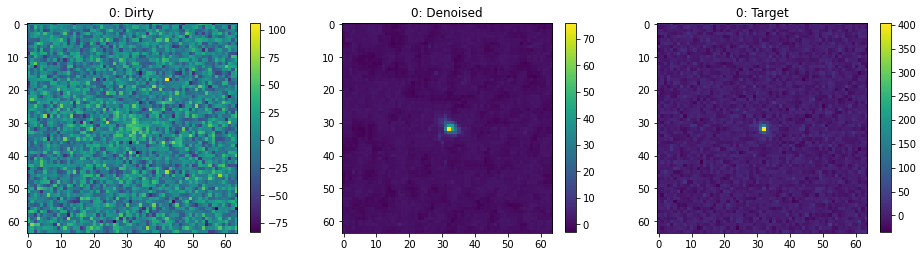

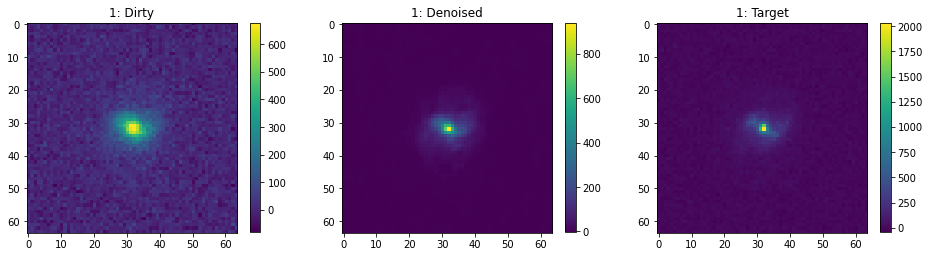

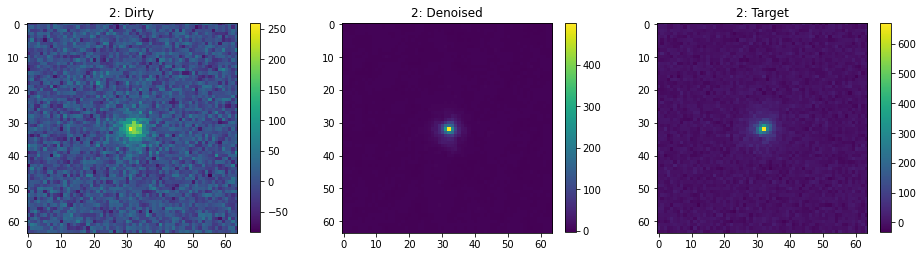

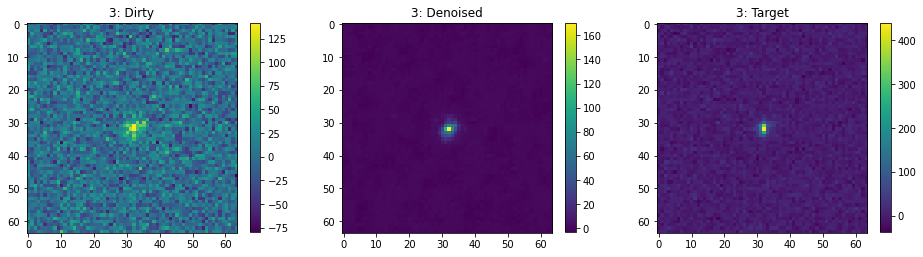

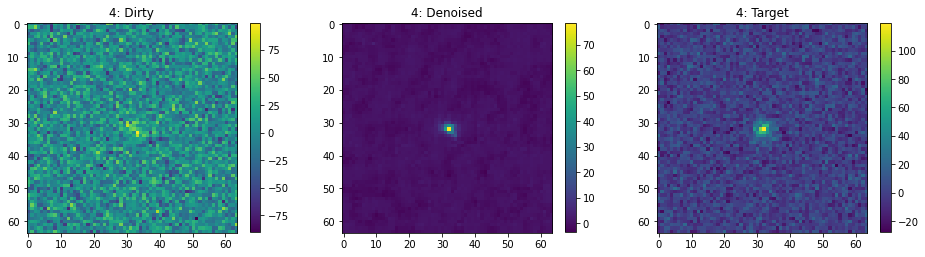

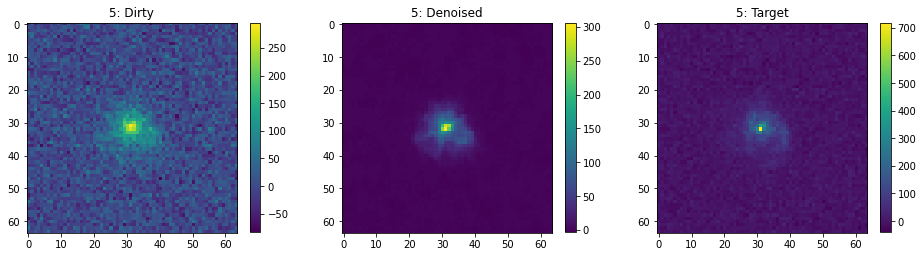

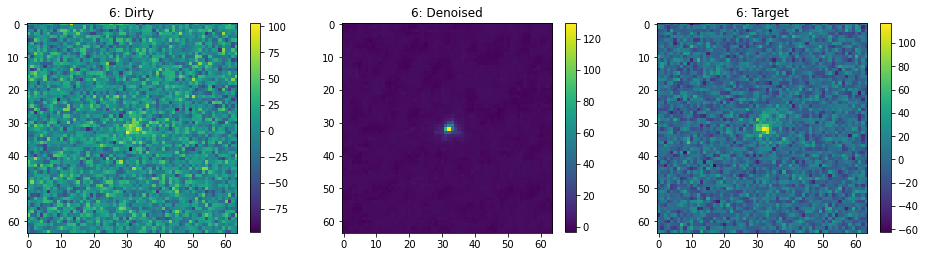

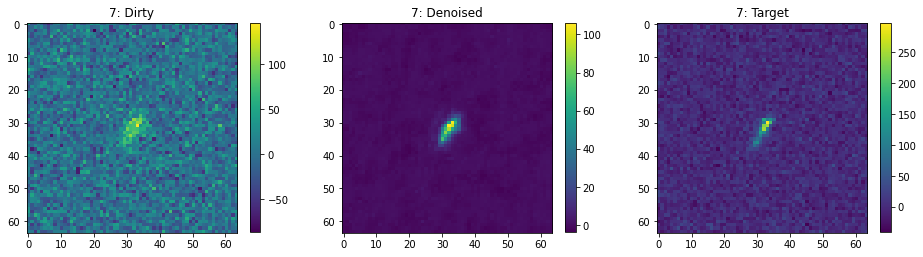

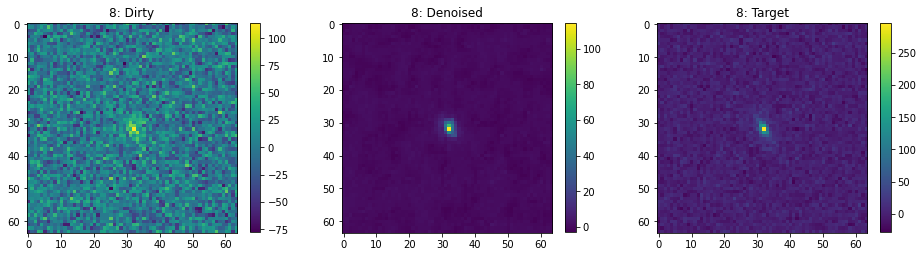

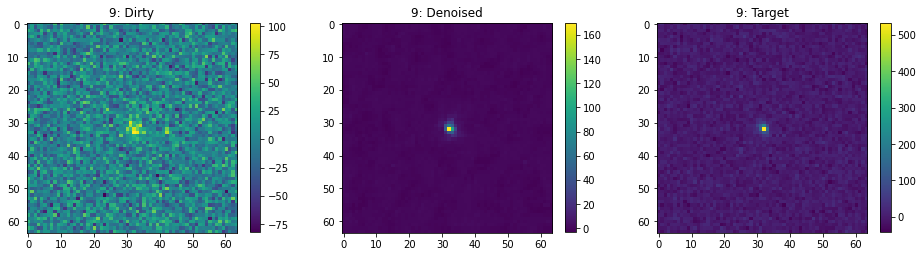

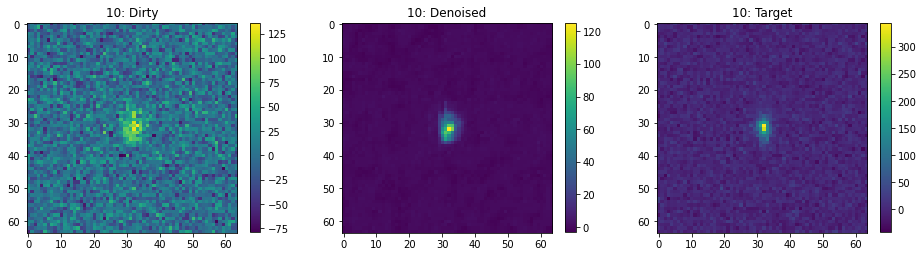

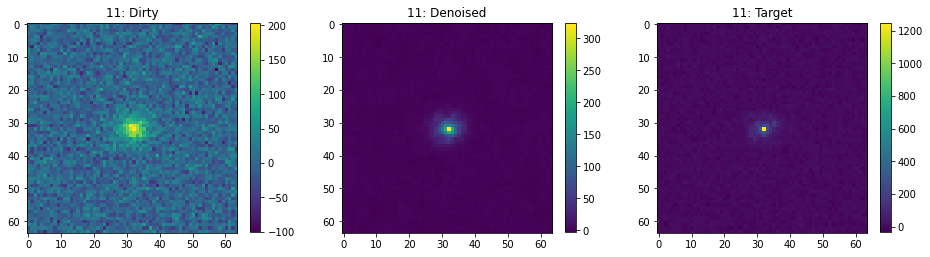

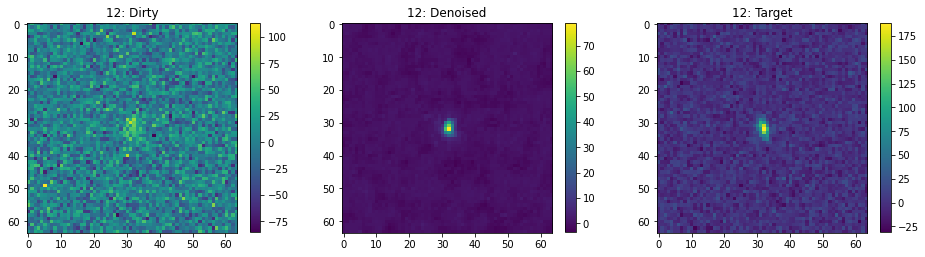

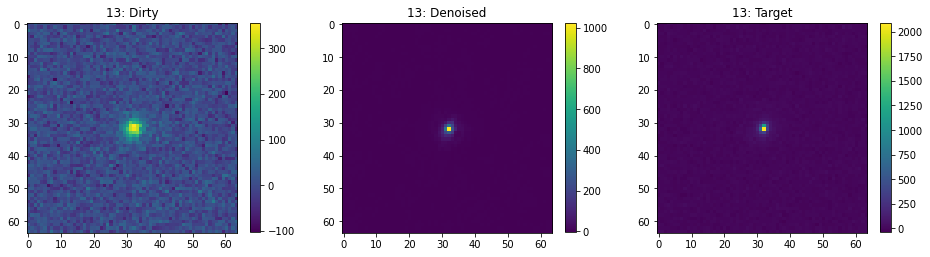

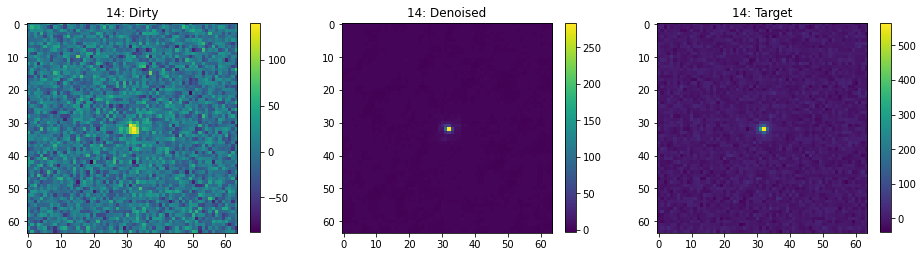

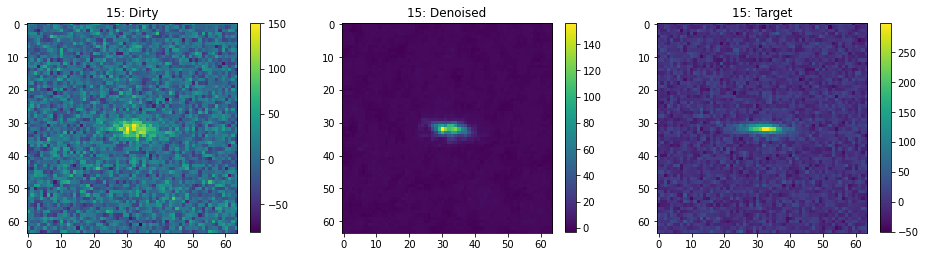

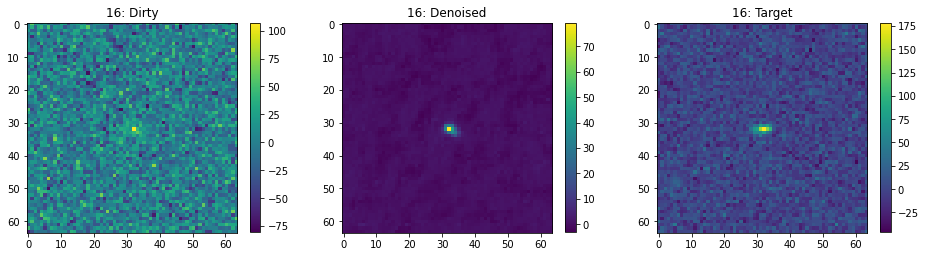

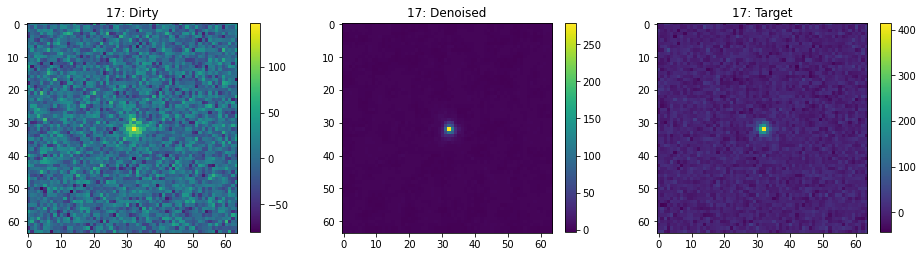

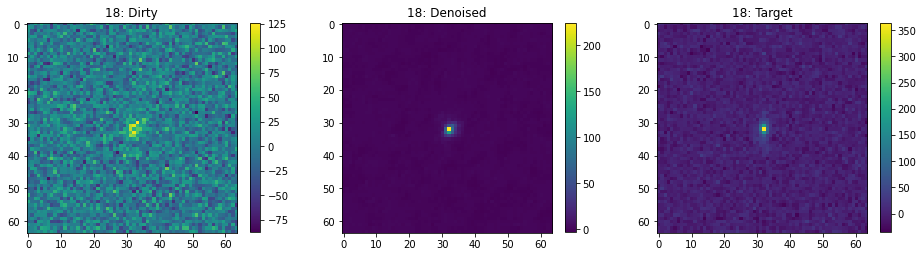

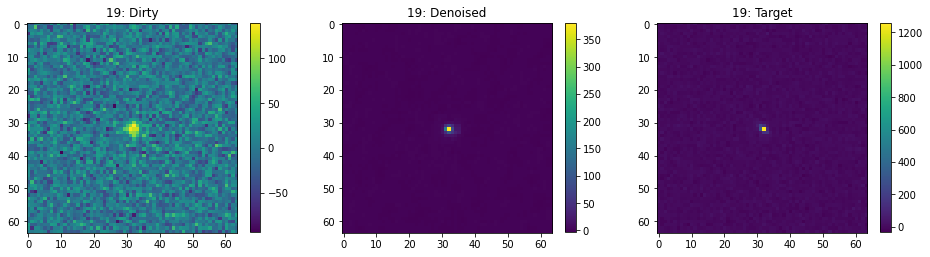

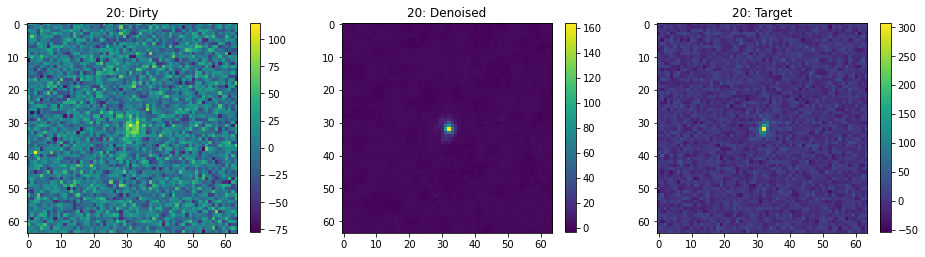

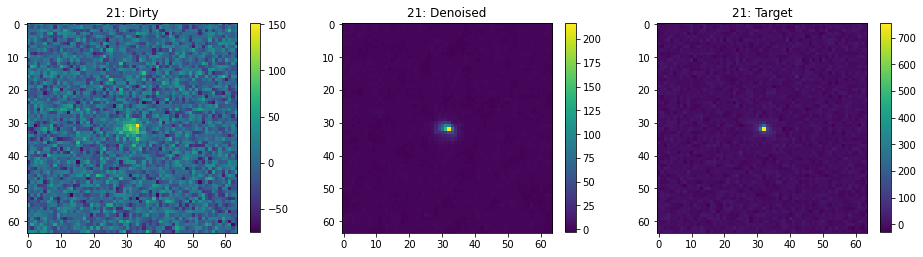

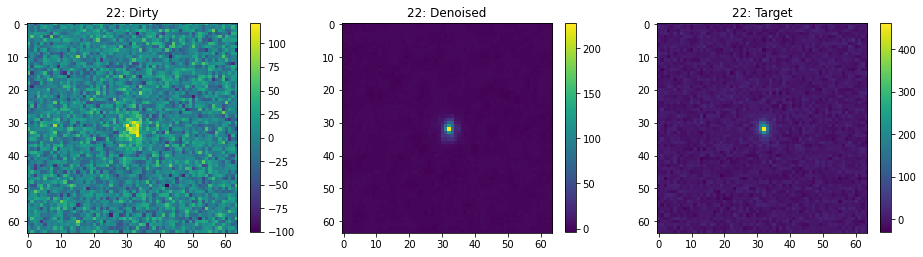

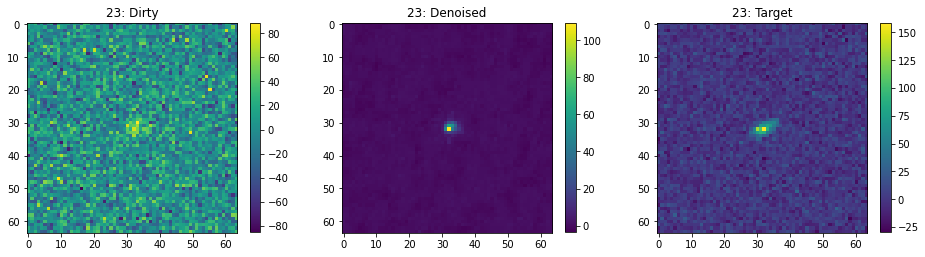

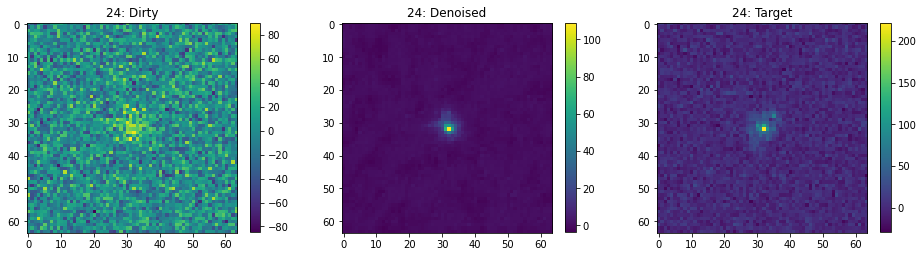

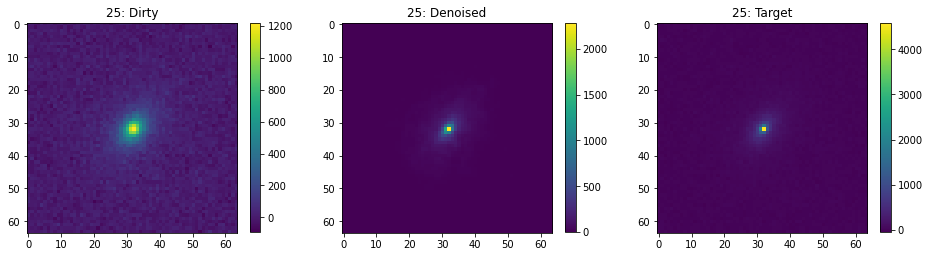

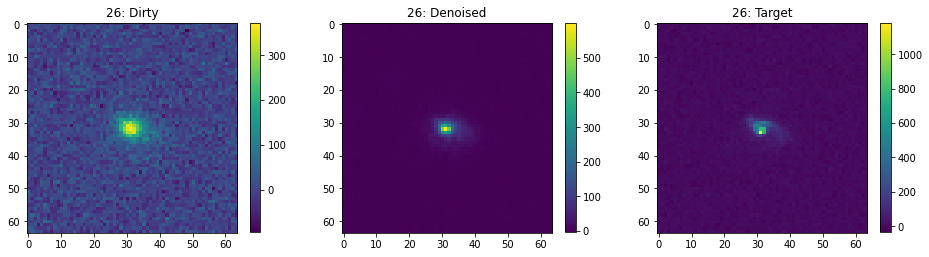

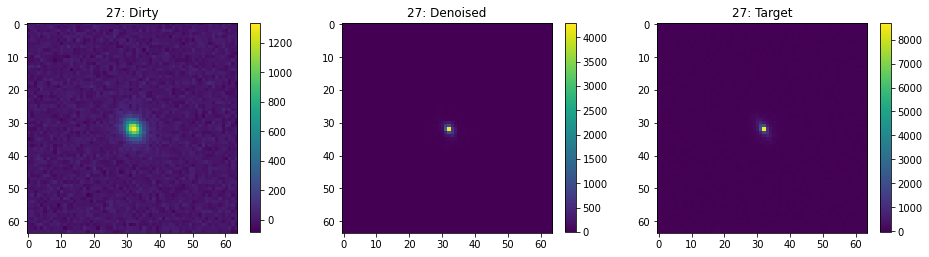

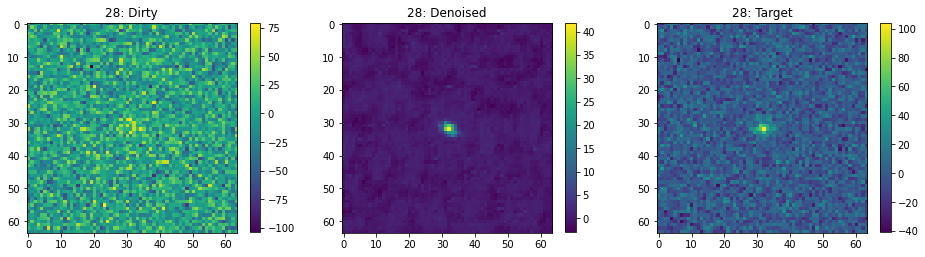

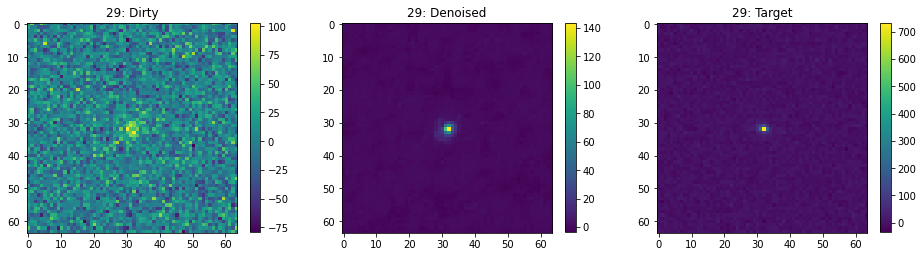

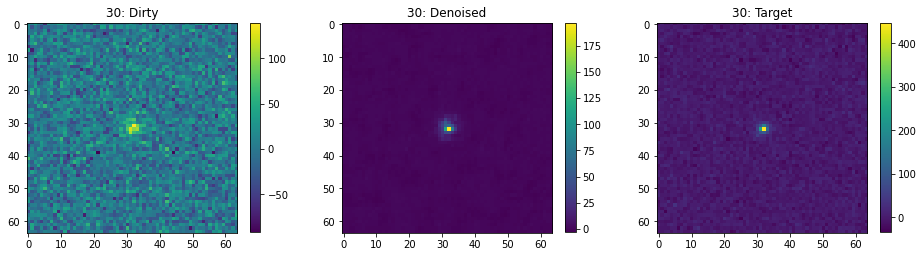

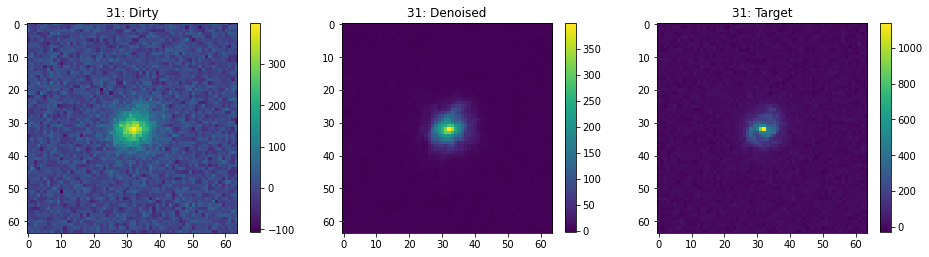

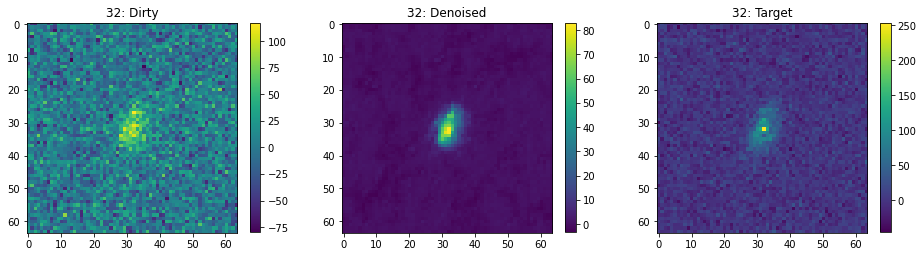

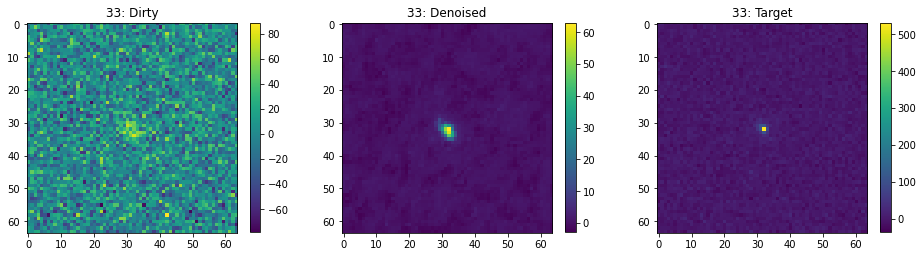

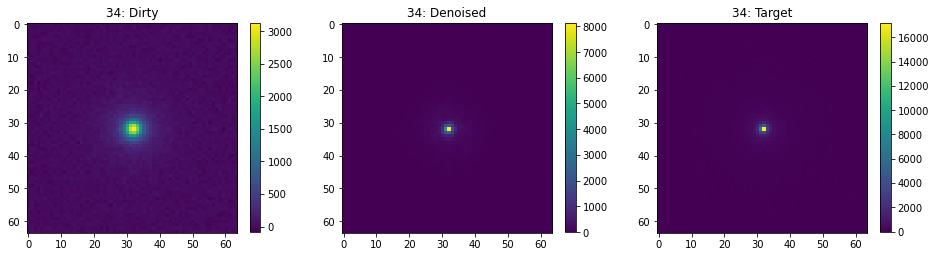

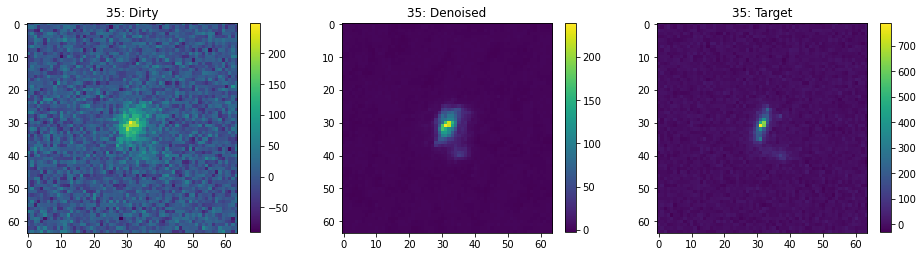

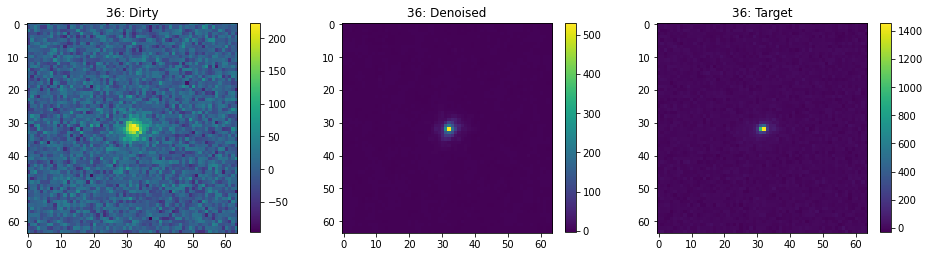

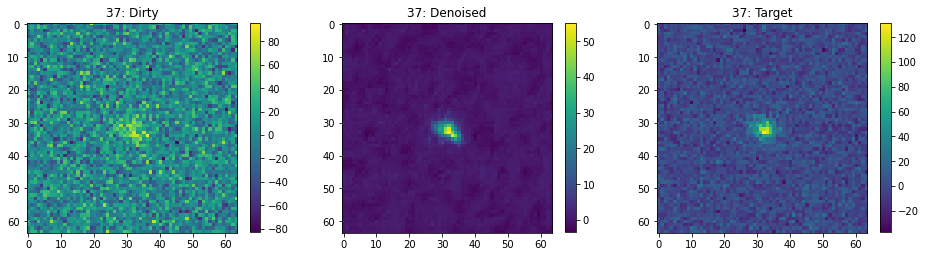

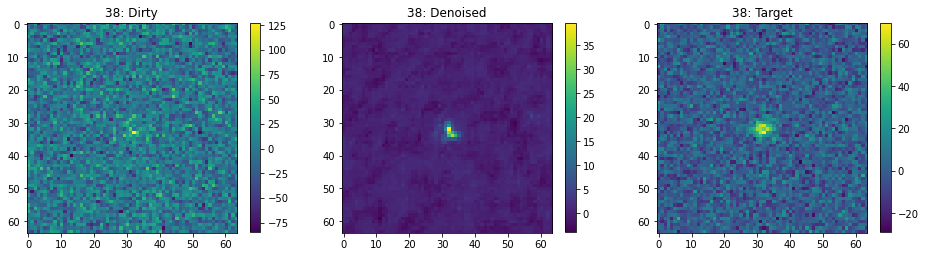

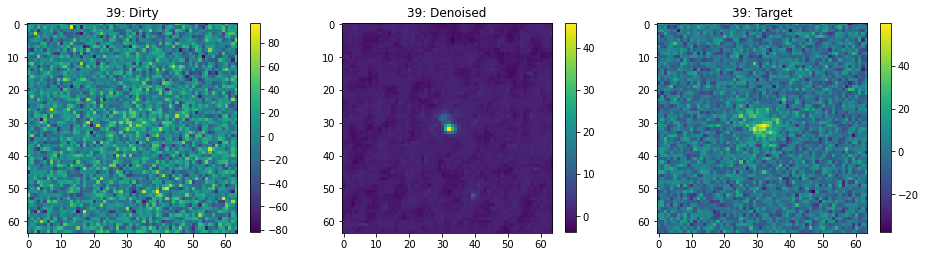

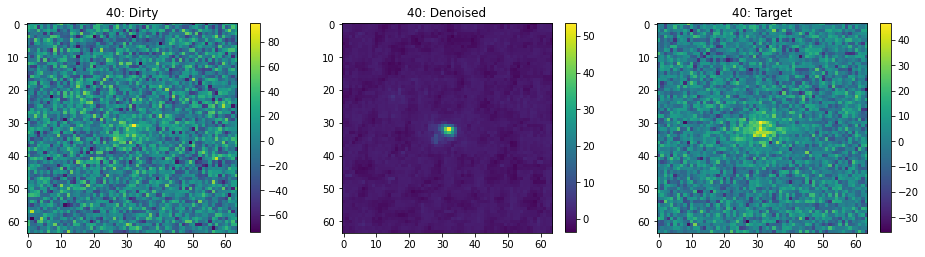

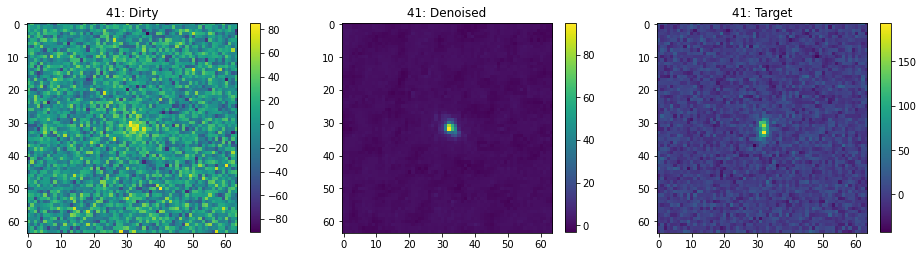

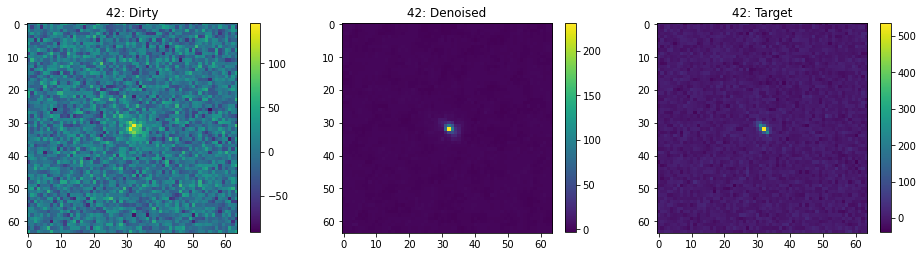

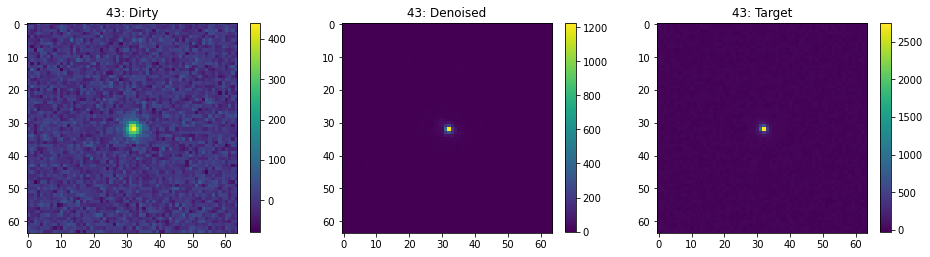

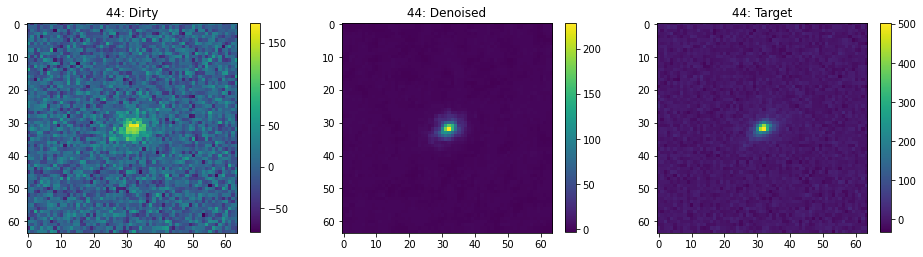

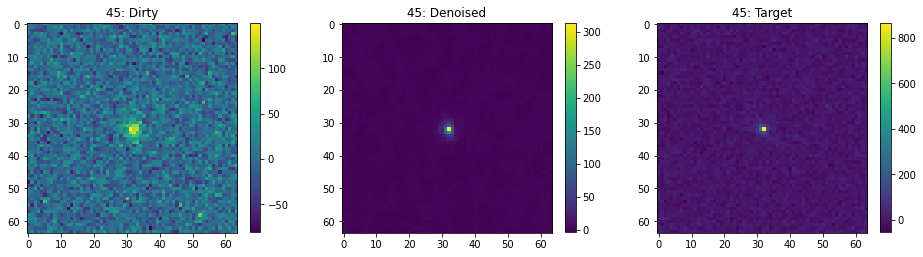

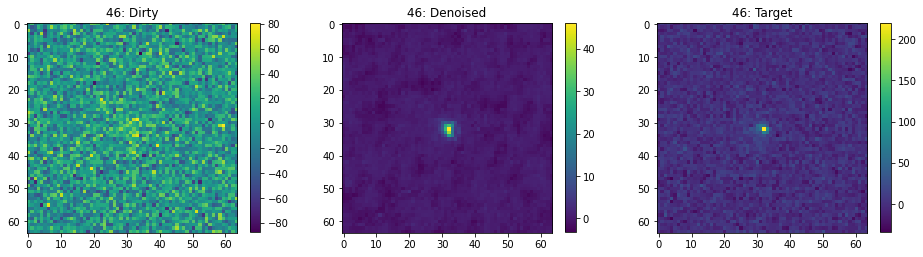

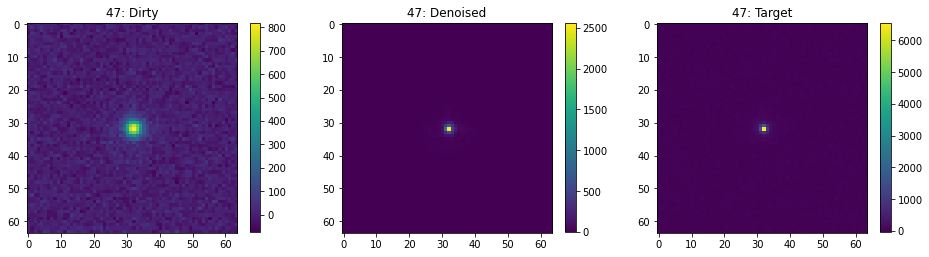

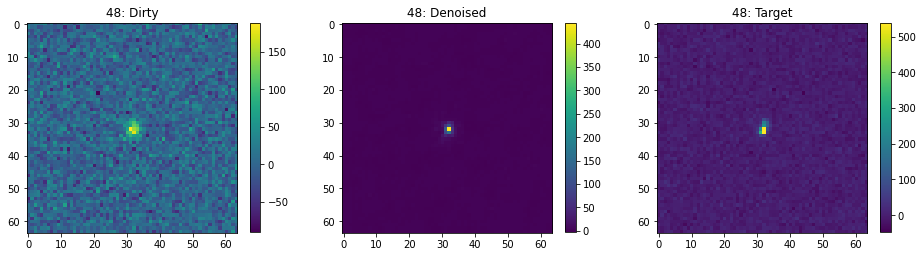

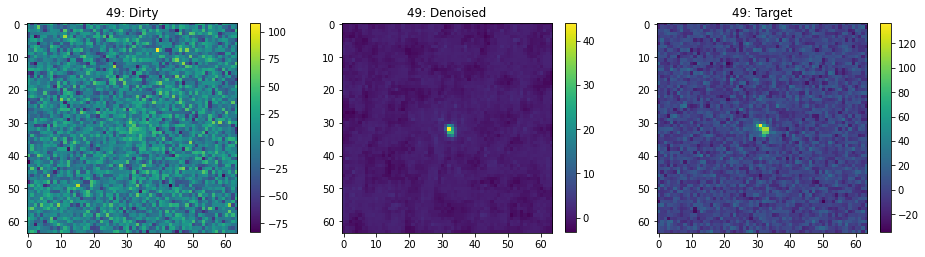

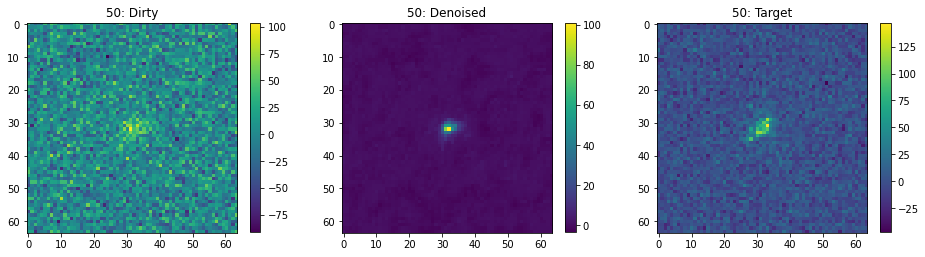

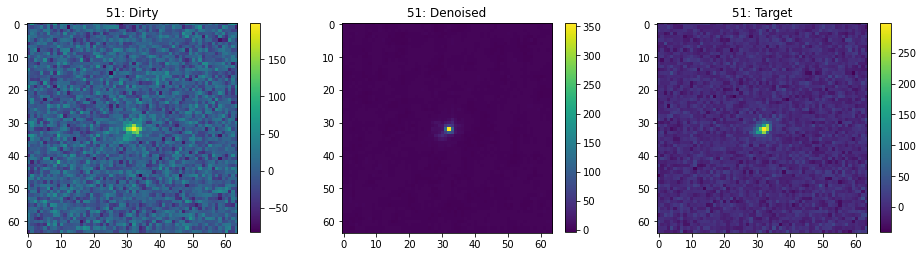

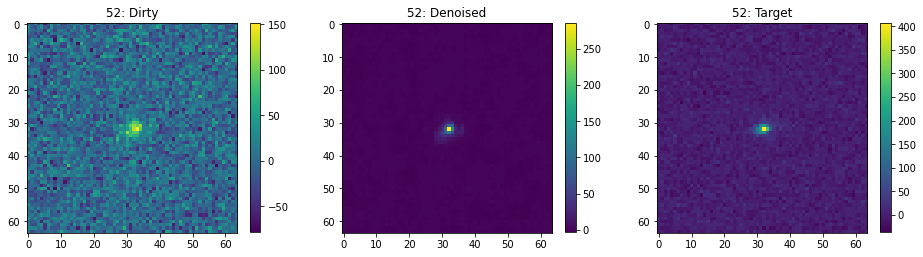

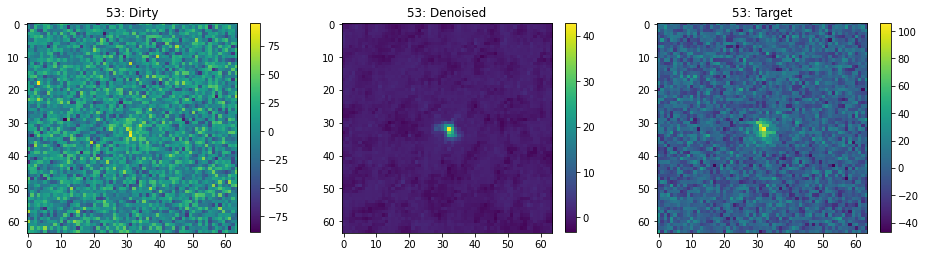

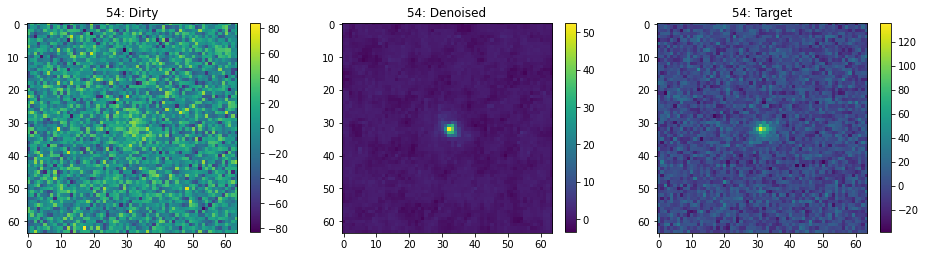

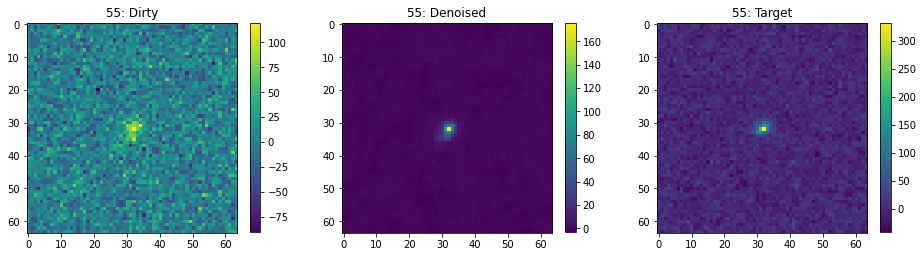

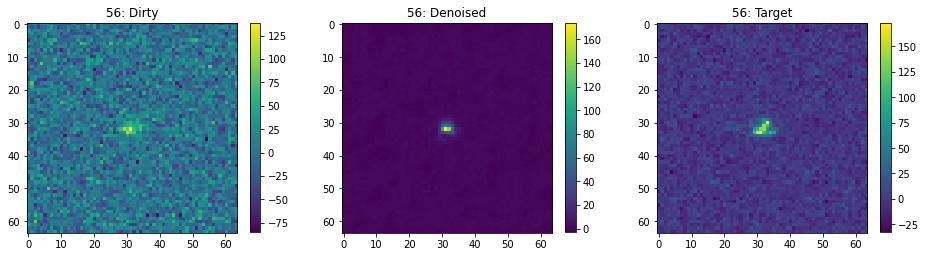

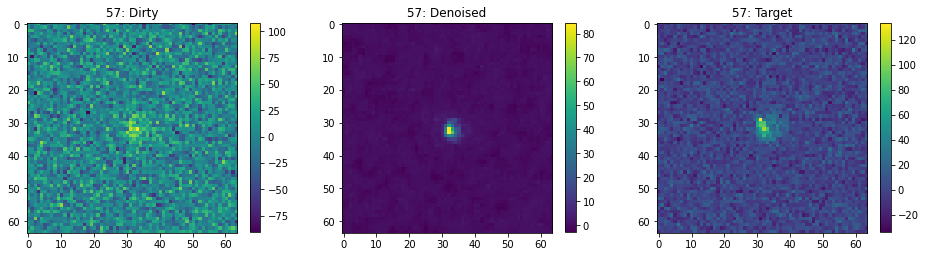

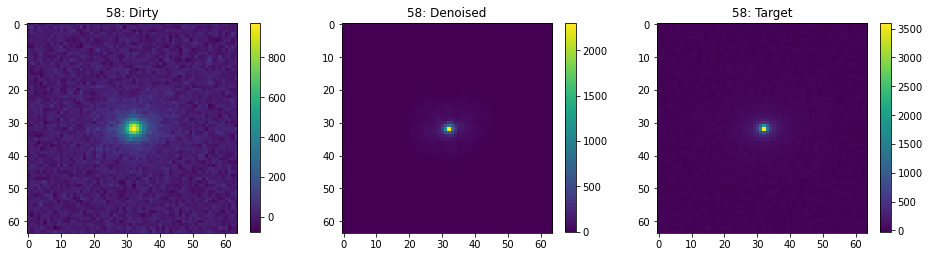

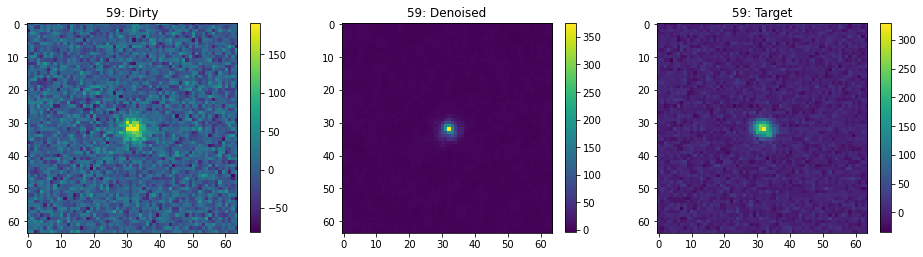

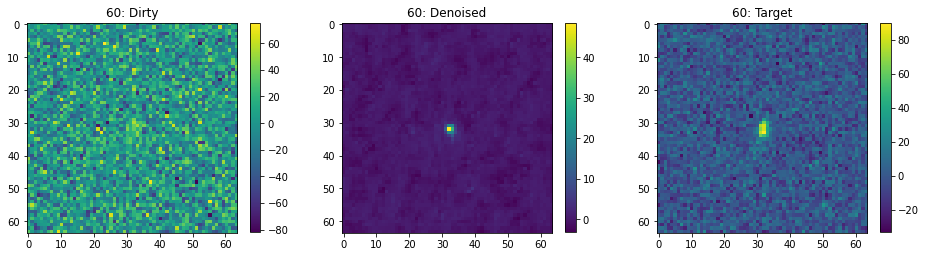

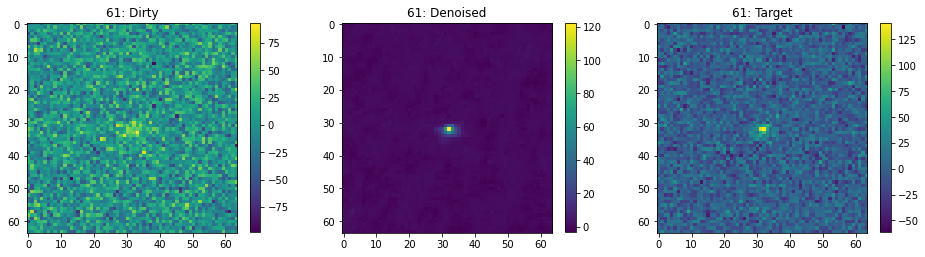

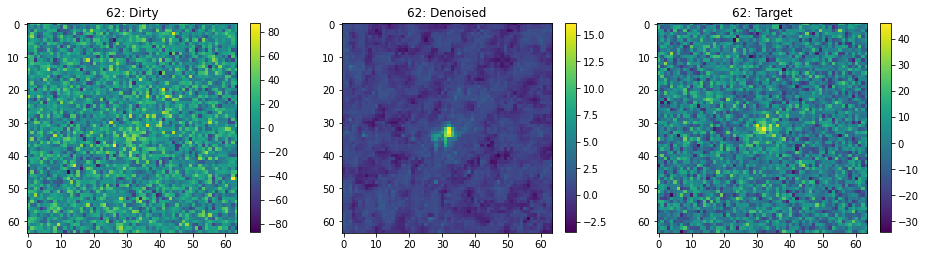

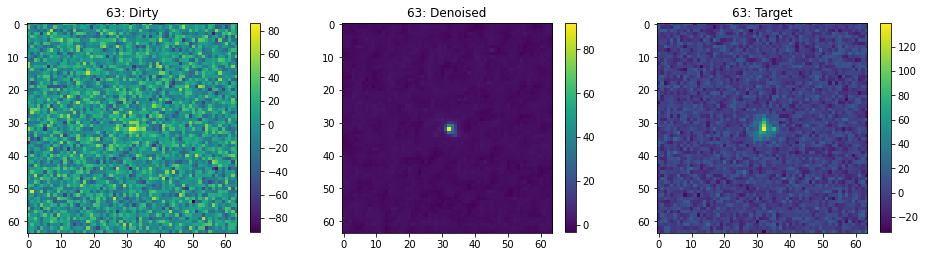

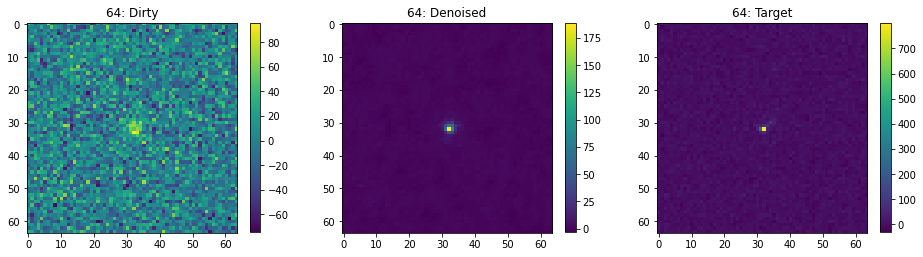

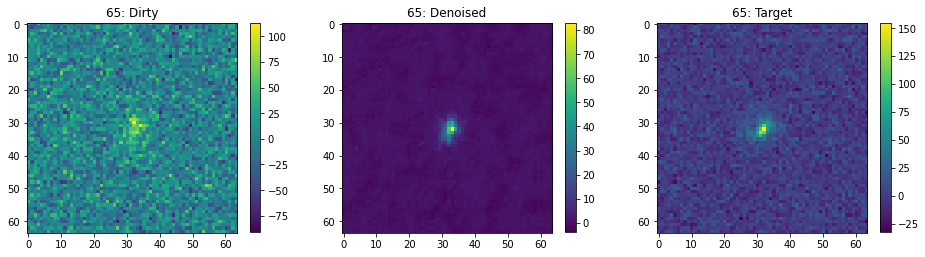

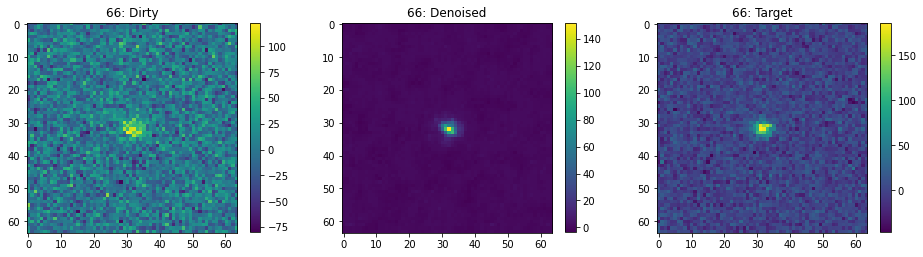

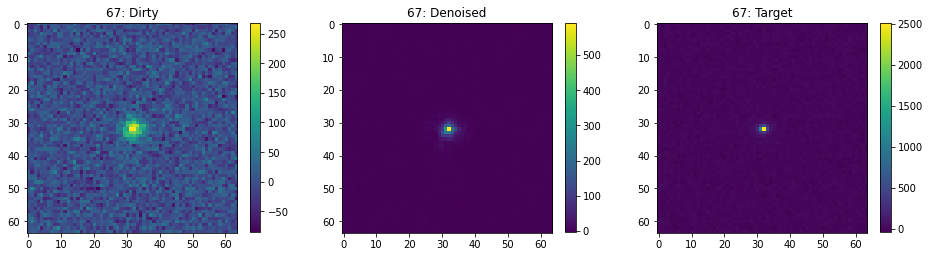

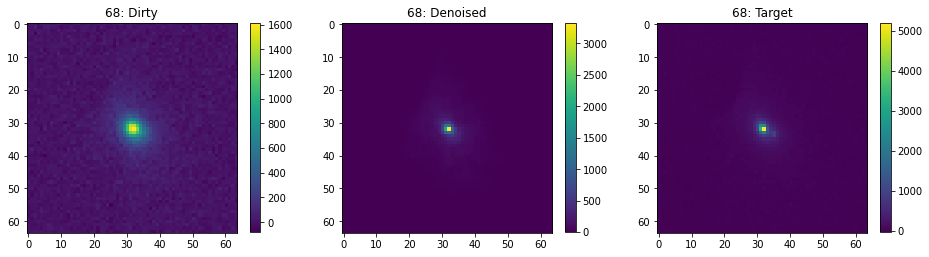

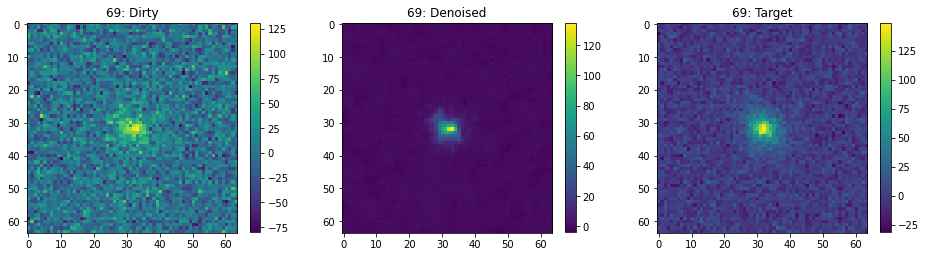

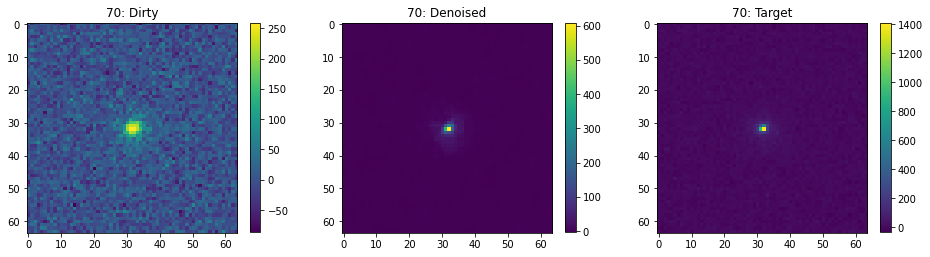

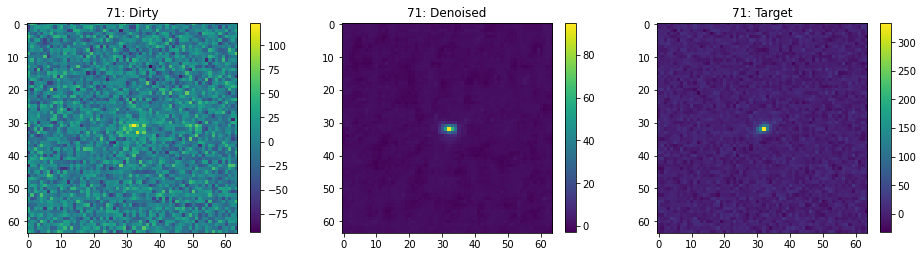

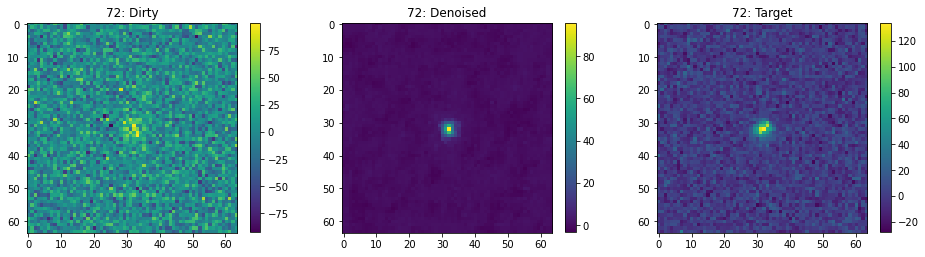

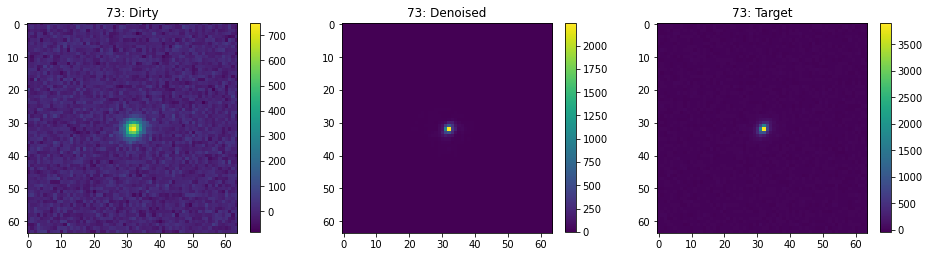

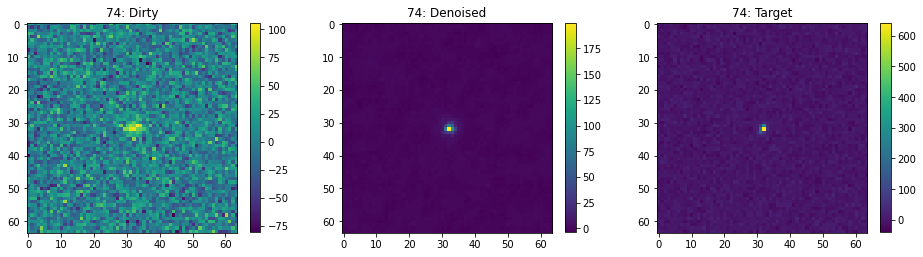

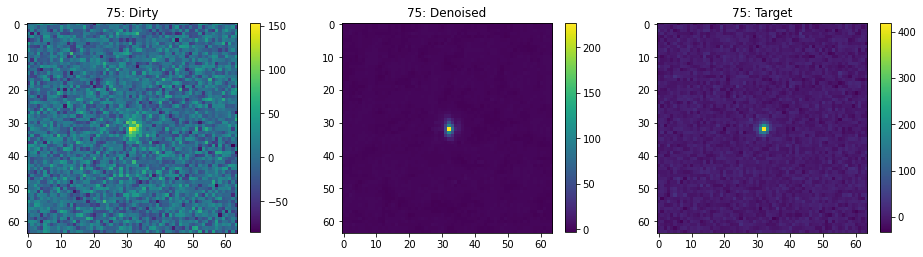

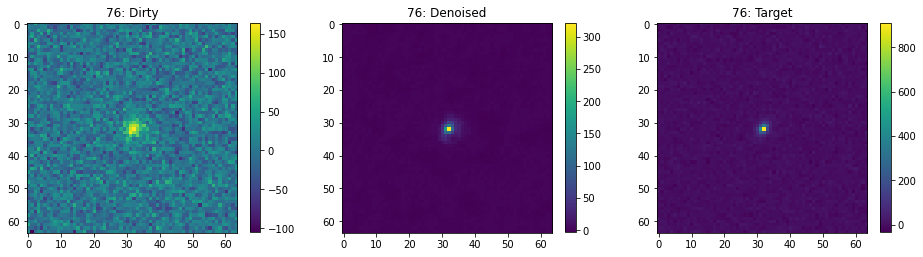

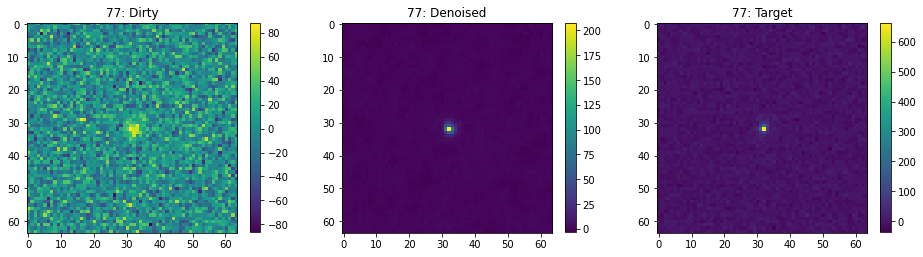

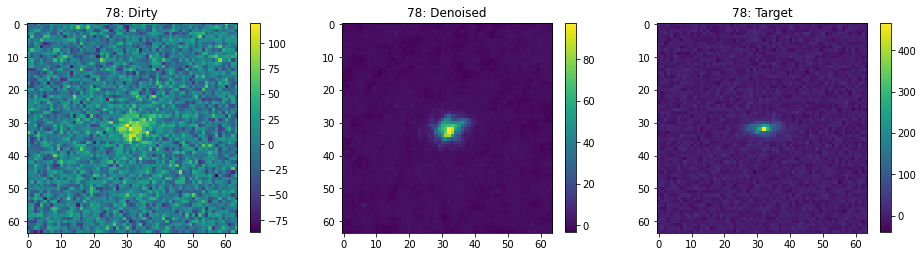

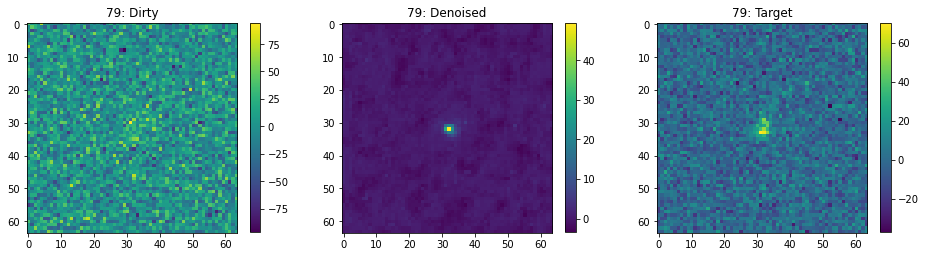

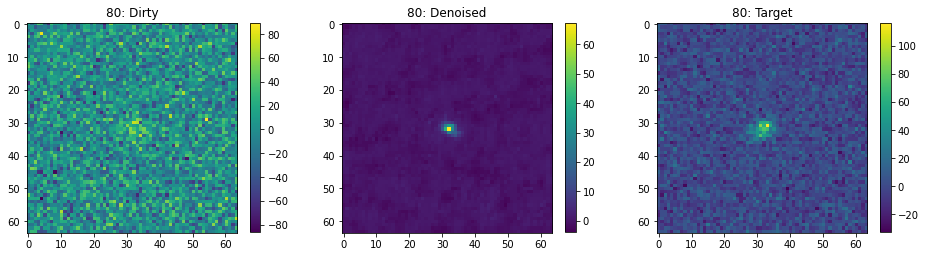

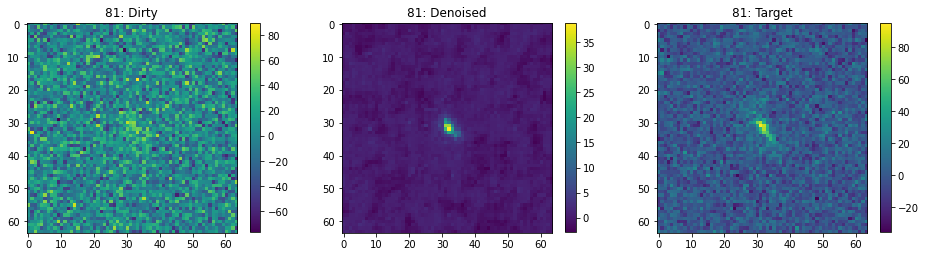

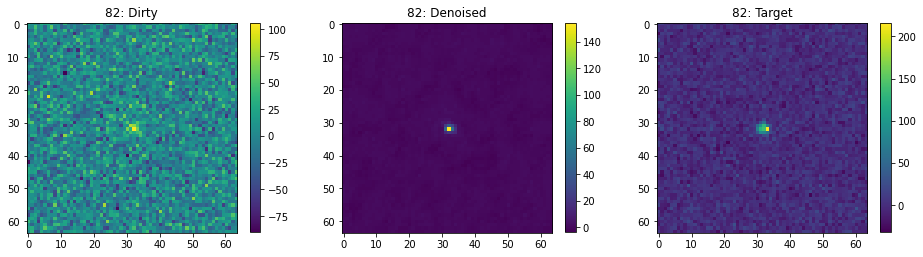

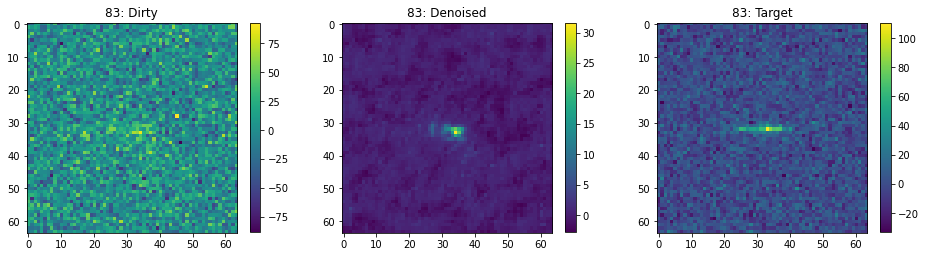

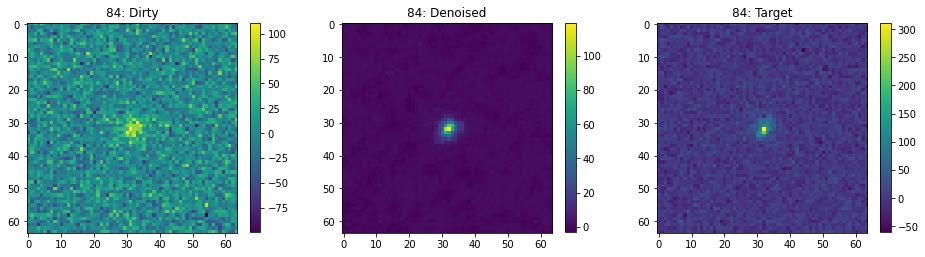

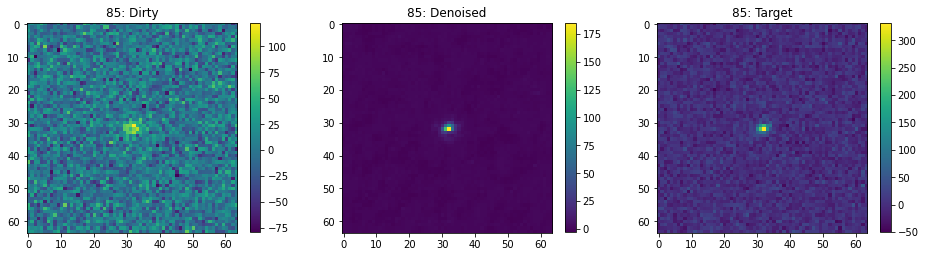

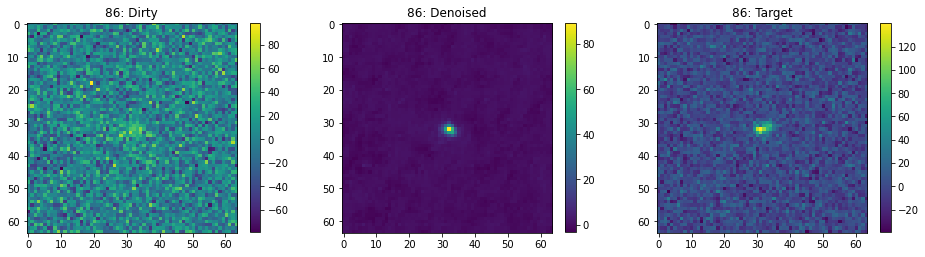

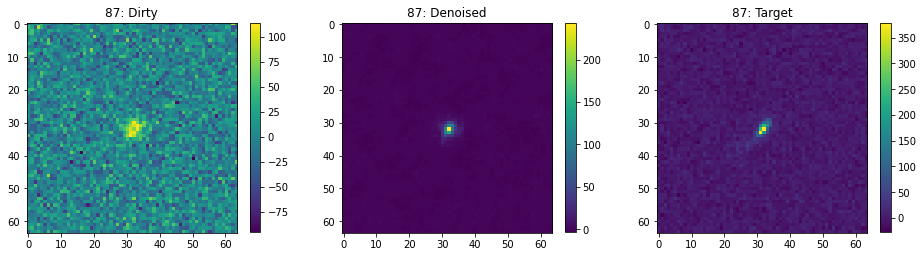

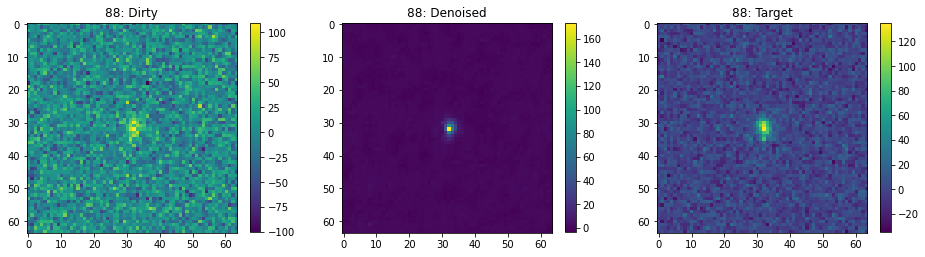

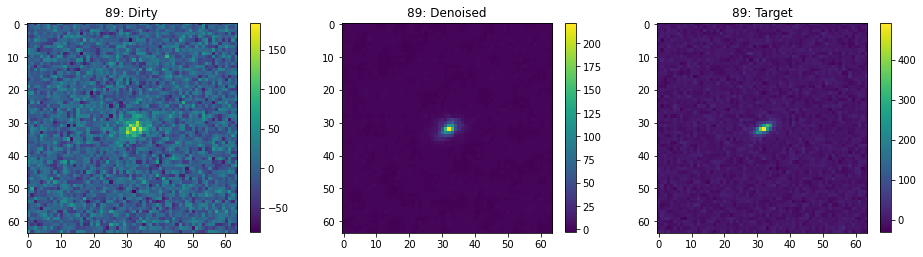

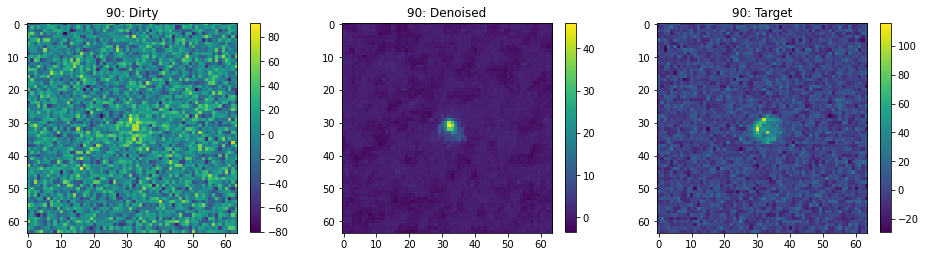

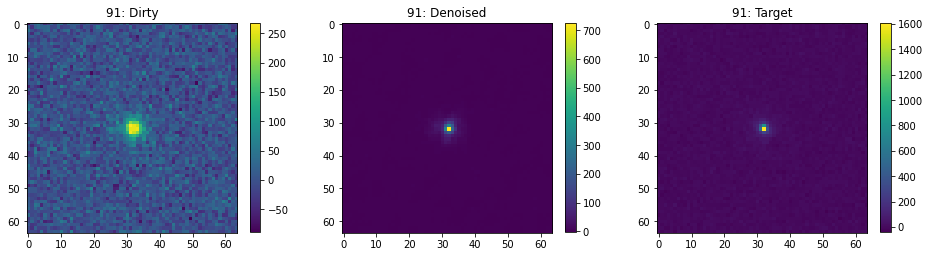

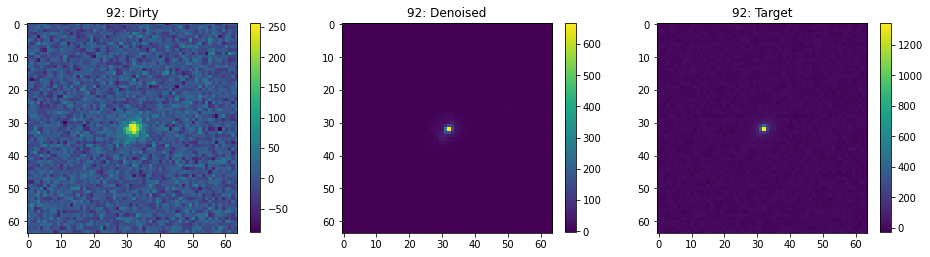

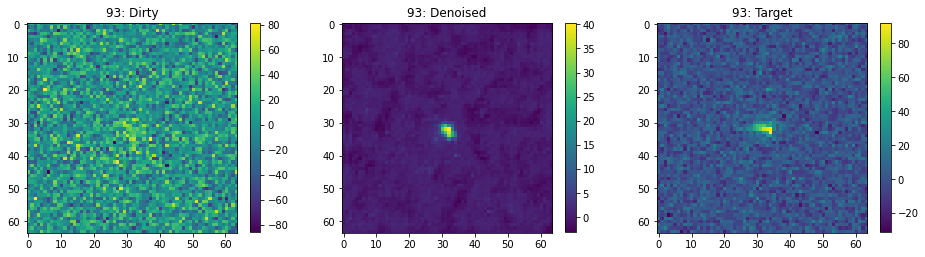

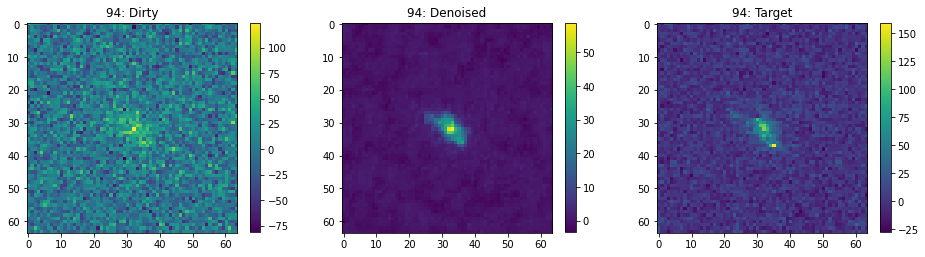

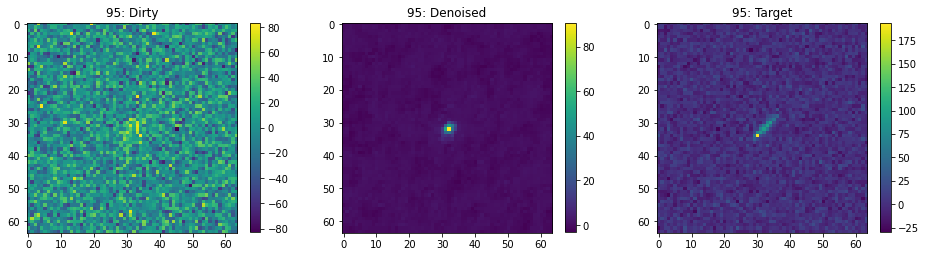

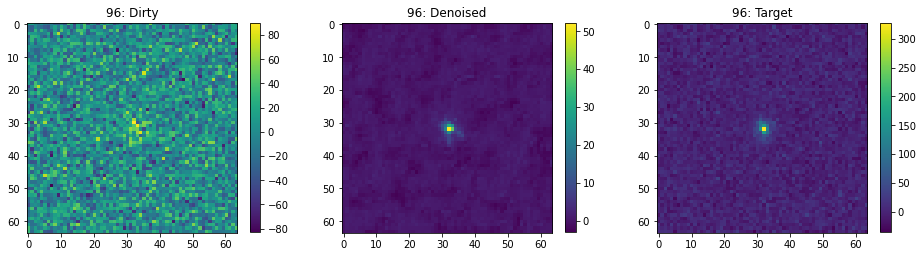

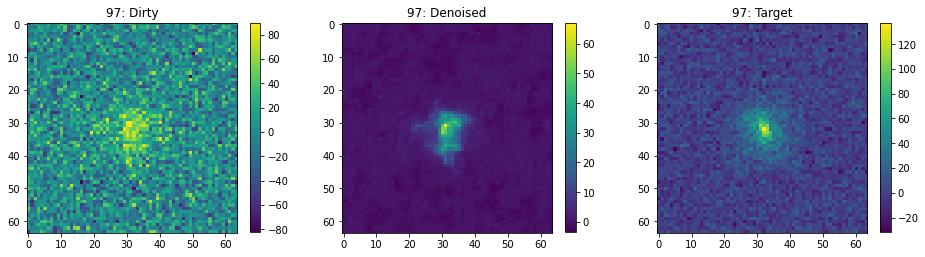

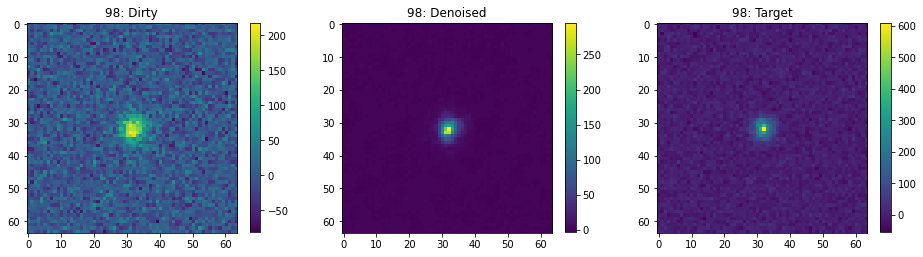

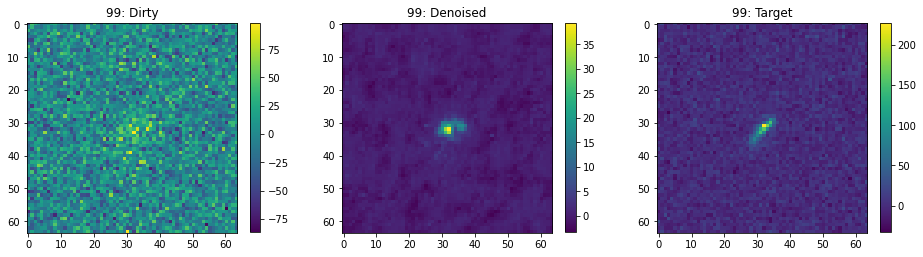

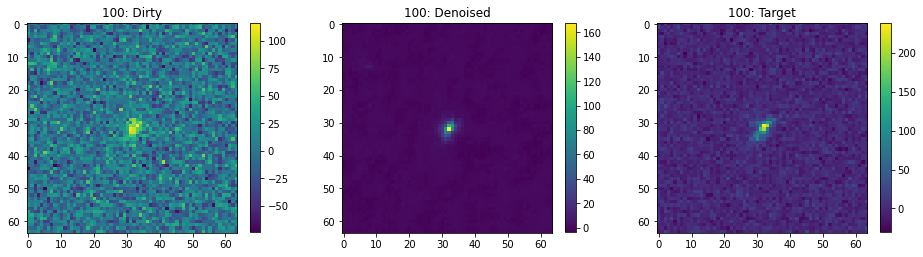

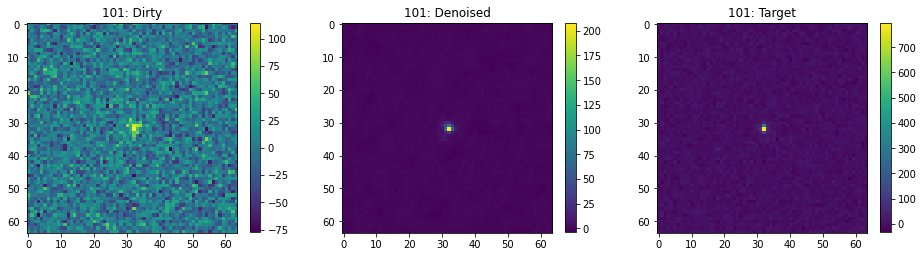

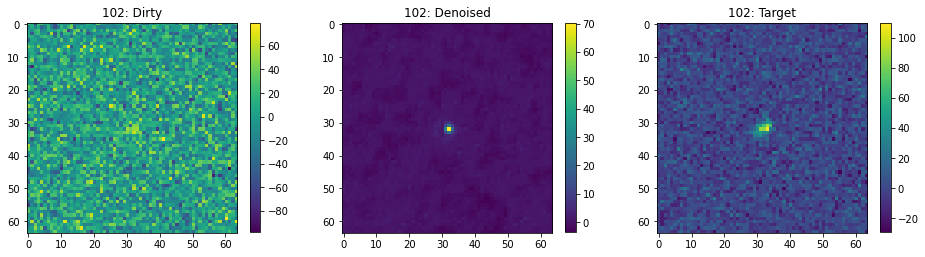

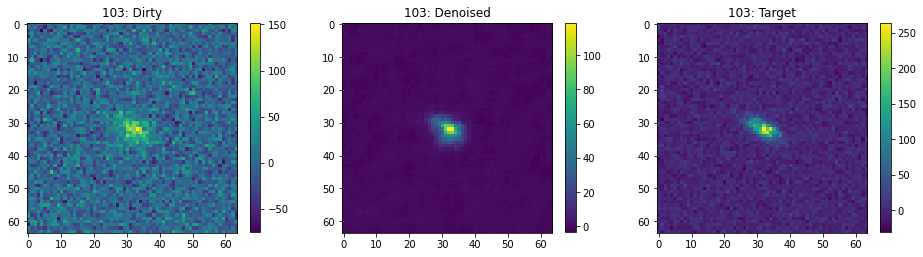

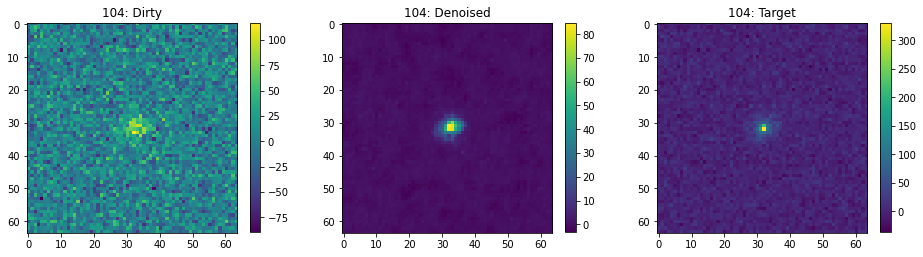

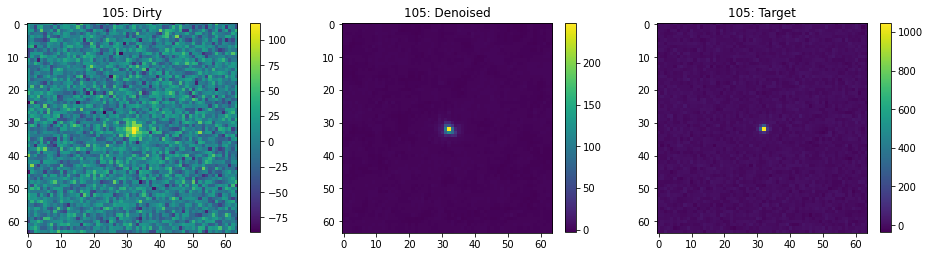

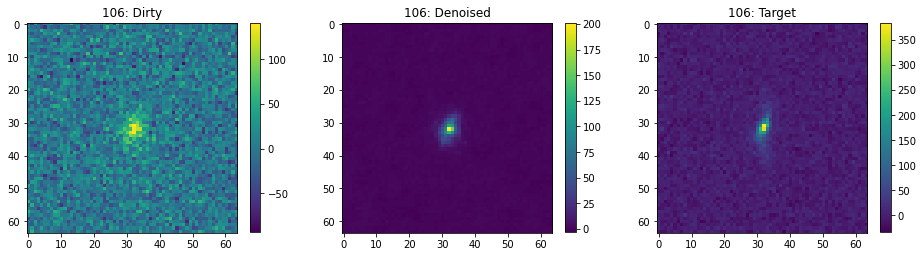

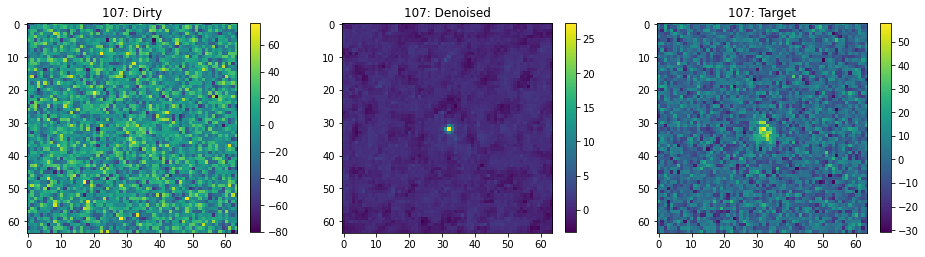

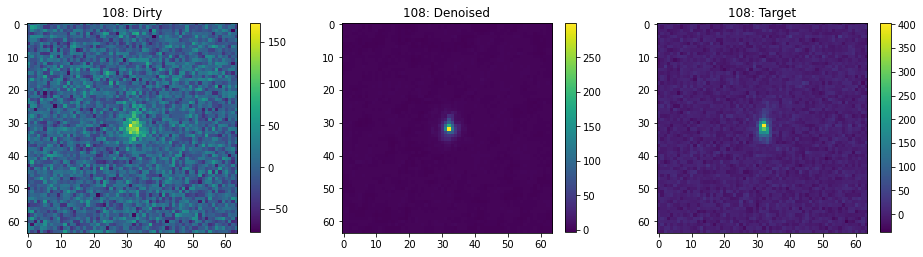

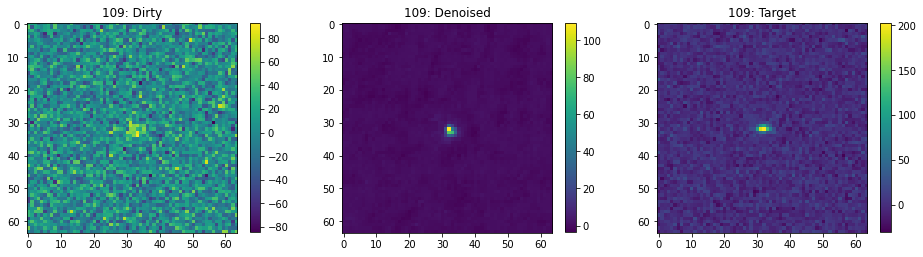

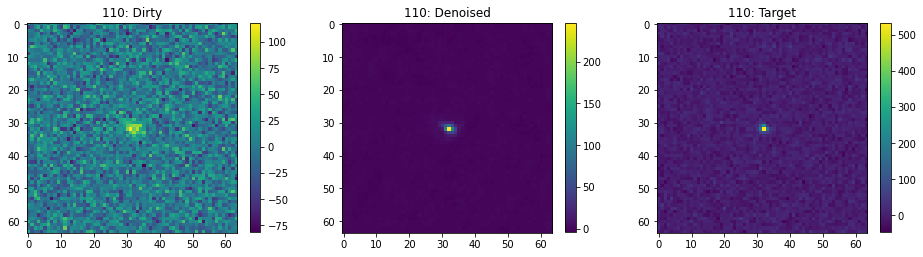

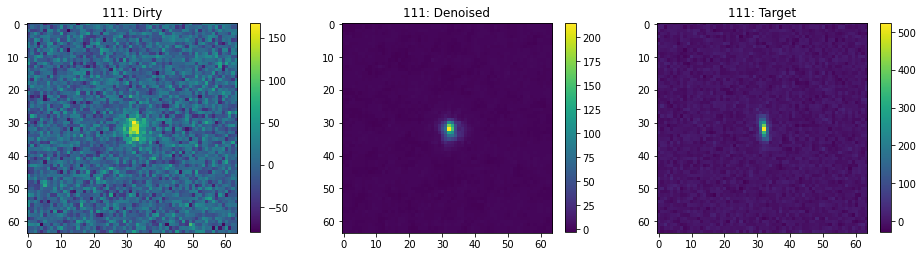

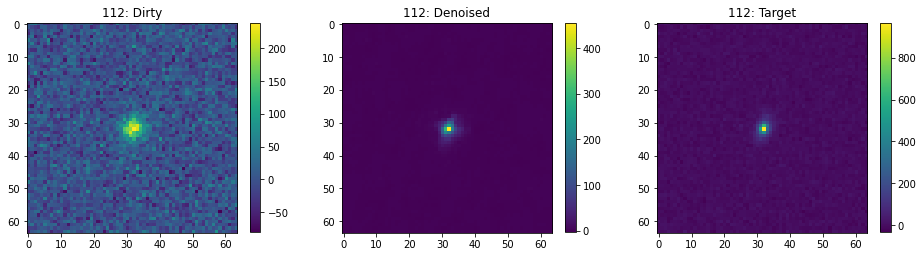

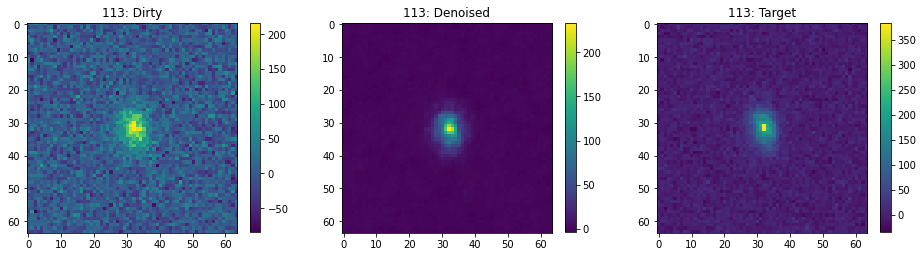

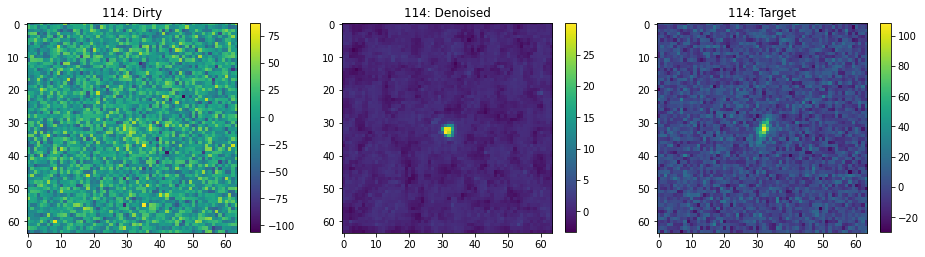

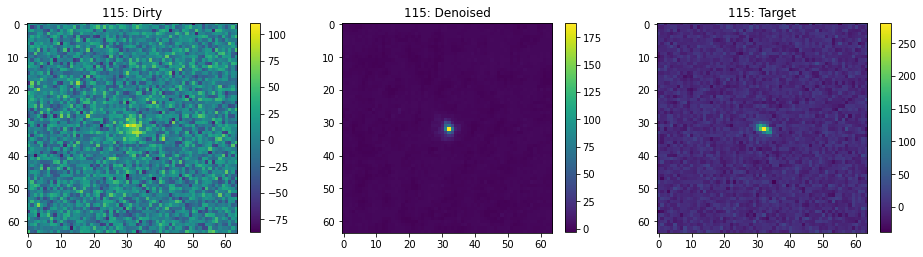

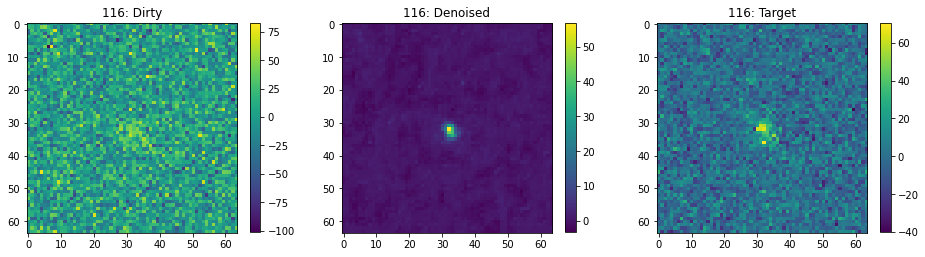

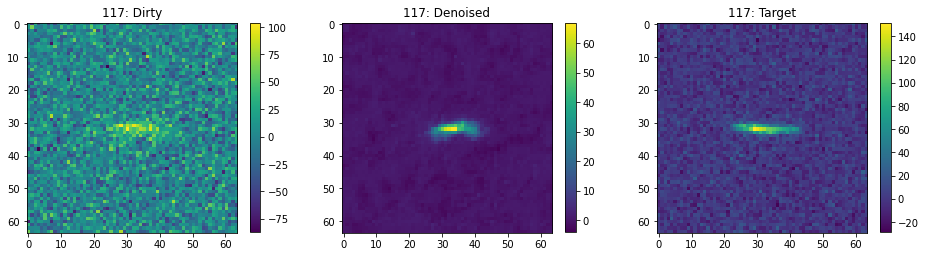

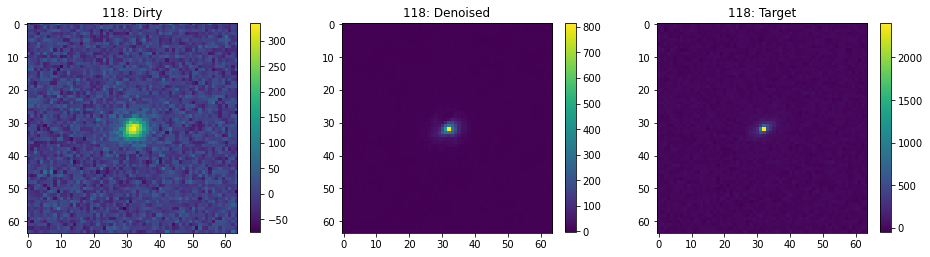

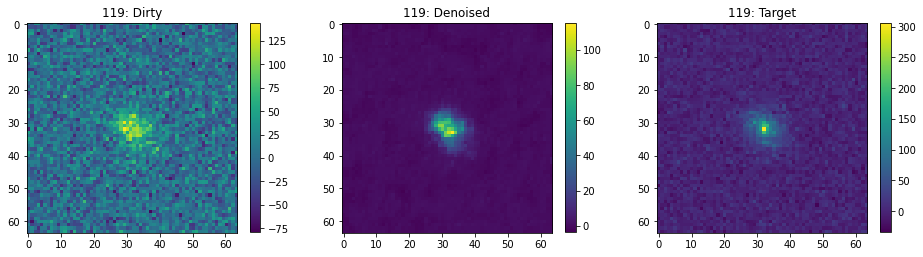

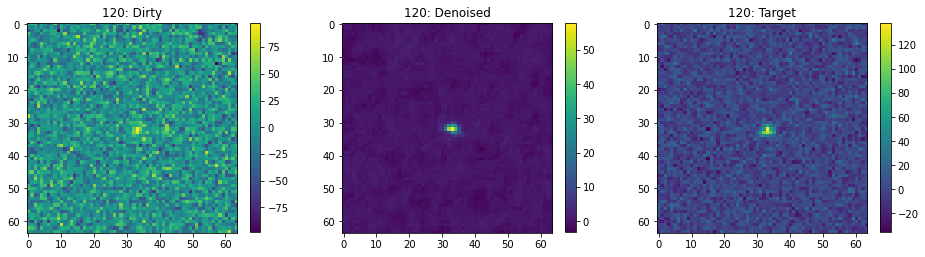

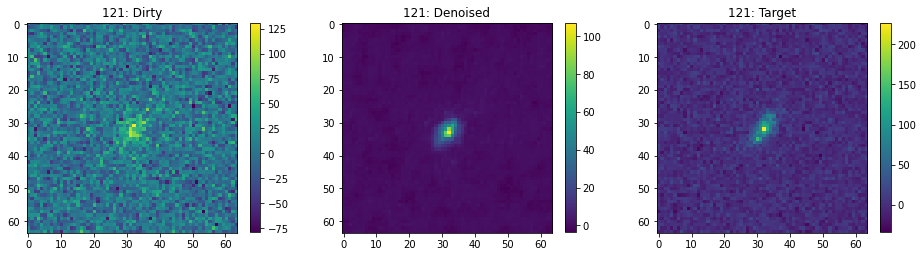

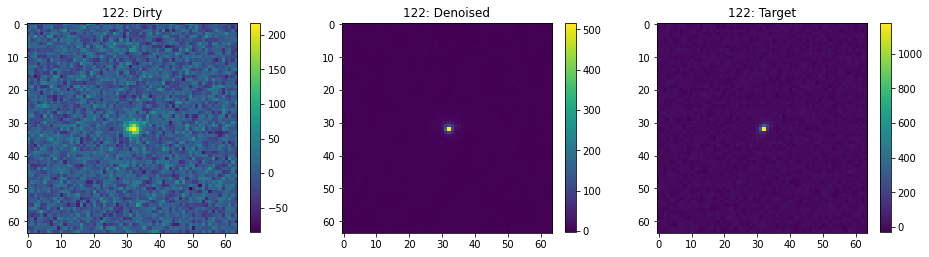

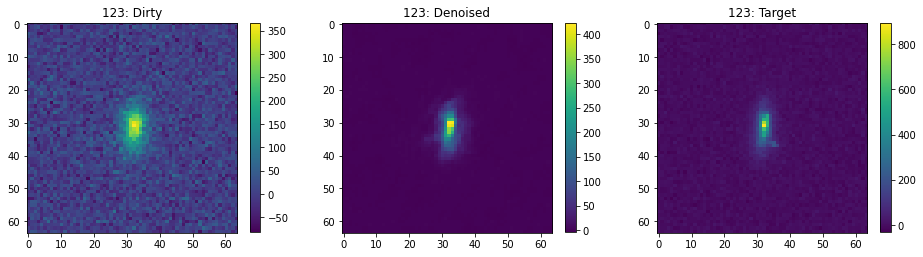

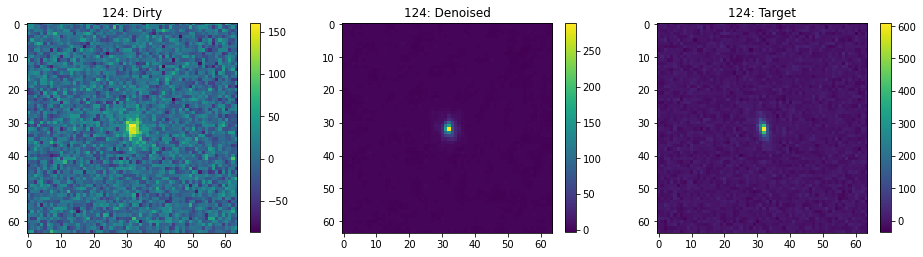

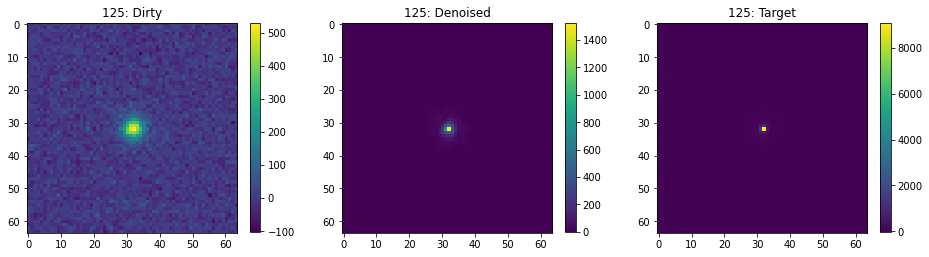

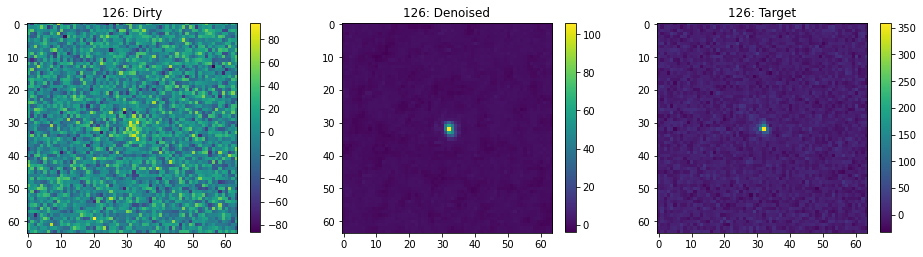

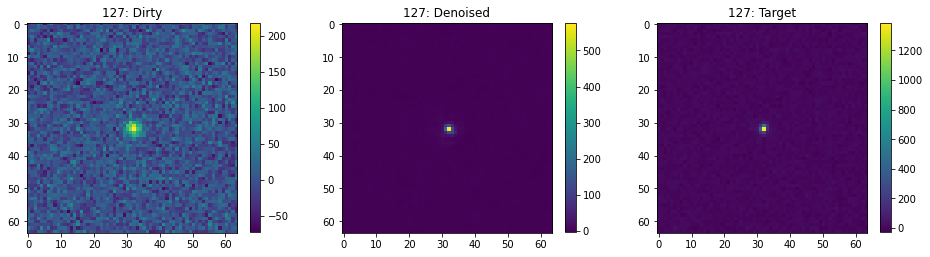

In [6]:
# Comparison

def compare_vis(index):
    fig = plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(batch[0][index].squeeze(axis=-1))
    plt.title('{}: Dirty'.format(index))
    plt.colorbar(shrink=0.24)
    plt.subplot(132)
    plt.imshow(res_np[index])
    plt.title('{}: Denoised'.format(index))
    plt.colorbar(shrink=0.24)
    plt.subplot(133)
    plt.imshow(batch[1][index].squeeze(axis=-1))
    plt.title('{}: Target'.format(index))
    plt.colorbar(shrink=0.24)
    plt.show(fig)
   
    
for i in range(0, n_batch):
    compare_vis(i)

In [7]:
def nmse(signal_1, singal_2):
    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)

err = np.zeros(n_batch)

for i in range(n_batch):
    err[i] = nmse(batch[1][i].squeeze(axis=-1), res_np[i])
    
err

array([0.86297358, 0.22303983, 0.30622474, 0.69244711, 0.88882981,
       0.31498185, 0.94637916, 0.71796665, 0.72428353, 0.78487403,
       0.64330748, 0.47590898, 0.81074788, 0.31105061, 0.66383913,
       0.63839486, 0.92304566, 0.6991065 , 0.71561459, 0.55589142,
       0.82678204, 0.61665918, 0.54040692, 0.83309617, 0.75580645,
       0.18568368, 0.31138223, 0.25834726, 0.95142759, 0.70791179,
       0.66465231, 0.2677961 , 0.66717066, 0.84284583, 0.24251973,
       0.44893712, 0.45616793, 0.78136464, 0.95212302, 0.95844157,
       0.9531852 , 0.85573602, 0.65726271, 0.32838652, 0.42256624,
       0.68277794, 0.90440971, 0.35606159, 0.56788408, 0.93404701,
       0.8584268 , 0.69328765, 0.59633164, 0.94959673, 0.93119167,
       0.76920043, 0.75141317, 0.85399286, 0.16039737, 0.4285795 ,
       0.95849606, 0.949322  , 0.98925844, 0.89486439, 0.71678649,
       0.79839741, 0.77156686, 0.55714527, 0.17502589, 0.55101479,
       0.36688671, 0.78392745, 0.79960472, 0.22605237, 0.69343

In [8]:
flux_rad = batch[2]

In [9]:
np.size(flux_rad)

128

In [10]:
# Partition galaxies into bins of equal size

n_bins = 4

# Initialize lower bound
lower_bound = np.min(flux_rad)
gal_sum = 0
data_arr = [] 

for i in range(n_bins):

    # compute quantile that is used as an upper bound
    q = np.quantile(flux_rad,(i+1)/n_bins)

    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=flux_rad, flux_rad<=q)

    # retrieve corresponding objects
    mag_q = (flux_rad[cond], np.where(cond))
    print(i+1, lower_bound, q, mag_q)


    # update lower bound
    lower_bound = q

    data_arr.append(mag_q)

1 3.3951252 8.860638618469238 (array([7.3467283, 8.143344 , 8.332713 , 6.284625 , 4.5789533, 7.296929 ,
       8.225475 , 6.5244246, 8.3910265, 7.34728  , 7.4474974, 5.3899612,
       7.6953034, 6.453973 , 7.401162 , 5.0758886, 5.9576254, 7.3078156,
       3.3951252, 8.234164 , 7.8831244, 6.0963593, 8.013891 , 4.176715 ,
       4.4343023, 8.809432 , 6.201544 , 8.725938 , 4.492012 , 4.453173 ,
       7.024834 , 4.913582 ], dtype=float32), (array([  0,   9,  13,  14,  19,  21,  27,  29,  30,  36,  42,  43,  45,
        47,  48,  64,  67,  73,  74,  75,  76,  77,  92, 101, 105, 109,
       110, 115, 122, 125, 126, 127]),))
2 8.860638618469238 13.114337921142578 (array([ 9.569148 , 13.072878 , 11.320529 , 10.238129 ,  9.665555 ,
       12.289489 , 10.227374 , 10.443003 , 10.38535  , 12.036759 ,
       11.20902  , 11.22381  , 10.331163 , 10.071633 ,  9.909152 ,
       12.05647  , 12.221356 , 12.51065  ,  9.524928 ,  8.8777075,
        9.180771 , 12.38474  , 10.664856 , 10.226944 , 10.707277

In [11]:
# Flux Radii and their correspoding indices for one bin 
data_arr[0]

(array([7.3467283, 8.143344 , 8.332713 , 6.284625 , 4.5789533, 7.296929 ,
        8.225475 , 6.5244246, 8.3910265, 7.34728  , 7.4474974, 5.3899612,
        7.6953034, 6.453973 , 7.401162 , 5.0758886, 5.9576254, 7.3078156,
        3.3951252, 8.234164 , 7.8831244, 6.0963593, 8.013891 , 4.176715 ,
        4.4343023, 8.809432 , 6.201544 , 8.725938 , 4.492012 , 4.453173 ,
        7.024834 , 4.913582 ], dtype=float32),
 (array([  0,   9,  13,  14,  19,  21,  27,  29,  30,  36,  42,  43,  45,
          47,  48,  64,  67,  73,  74,  75,  76,  77,  92, 101, 105, 109,
         110, 115, 122, 125, 126, 127]),))

In [12]:
# Max. intensity error values for one bin
err[data_arr[0][1]]

array([0.86297358, 0.78487403, 0.31105061, 0.66383913, 0.55589142,
       0.61665918, 0.25834726, 0.70791179, 0.66465231, 0.45616793,
       0.65726271, 0.32838652, 0.68277794, 0.35606159, 0.56788408,
       0.71678649, 0.55714527, 0.22605237, 0.69343963, 0.62465372,
       0.50327618, 0.65949279, 0.32789579, 0.68271279, 0.65301734,
       0.86924561, 0.74283341, 0.7404451 , 0.4120494 , 0.66408954,
       0.79623906, 0.43295116])

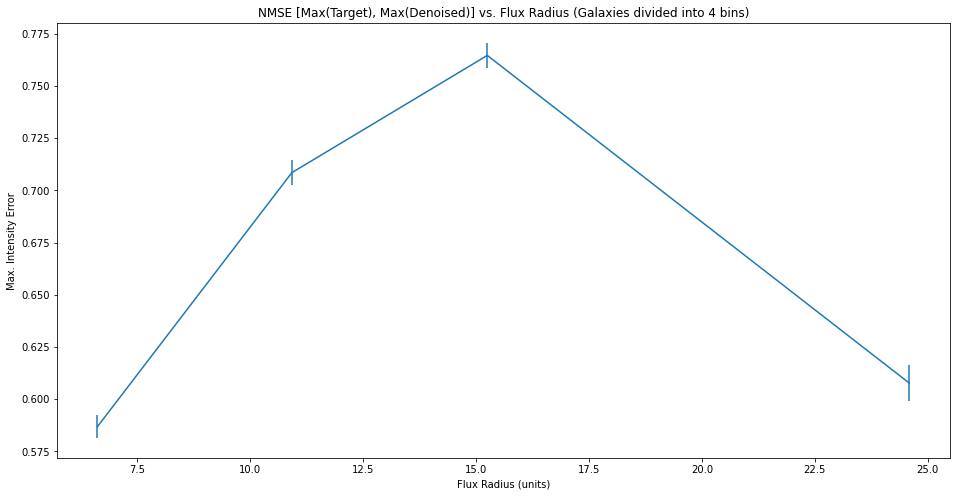

In [13]:
x_dat = []
y_dat = []
y_err = []

for i in range(n_bins):
    y_dat.append(np.mean(err[data_arr[i][1]]))
    y_err.append(np.std(err[data_arr[i][1]]) / np.size(err[data_arr[i][1]]))
    x_dat.append(np.mean(data_arr[i][0]))
    
plt.figure(figsize=(16,8)) 
plt.errorbar(x_dat, y_dat, yerr=y_err)
plt.title('NMSE [Max(Target), Max(Denoised)] vs. Flux Radius (Galaxies divided into 4 bins)')
plt.xlabel('Flux Radius (units)')
plt.ylabel('Max. Intensity Error')
plt.show()